In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from joblib import Parallel, delayed

In [ ]:
# ---------- Detection function ----------
def half_normal(x, sd):
    """Half-normal detection function."""
    return np.exp(-x**2 / (2 * sd**2))

def hazard_rate(x):
  shape = 5
  scale = 10.97
  return 1 - np.exp(-(x / scale)**(-shape))

# ---------- Array geometries ----------
def make_array(geometry='square', spacing=5.0, offset=4.0):
    """Return x, y coordinates for a given array geometry."""
    if geometry == 'square':
        xs = np.array([-1.5, -0.5, 0.5, 1.5, -1.5, -0.5, 0.5, 1.5]) * spacing
        ys = np.array([0, 0, 0, 0, 1, 1, 1, 1]) * spacing + offset
    elif geometry == 'triangular':
        xs = np.array([-spacing, 0, spacing, -spacing/2, spacing/2, -spacing, 0, spacing])
        ys = np.array([0, 0, 0, np.sqrt(3)/2*spacing, np.sqrt(3)/2*spacing,
                       np.sqrt(3)*spacing, np.sqrt(3)*spacing, np.sqrt(3)*spacing]) + offset
    elif geometry == 'line':
        xs = np.linspace(-3.5, 3.5, 8) * spacing
        ys = np.ones(8) * offset
    else:
        raise ValueError("Unsupported geometry type.")
    return xs, ys

# ---------- Distance and probability computations ----------
def compute_distances(xs, ys, grid_x, grid_y):
    """Compute distances from each hydrophone to each grid point."""
    gx, gy = np.meshgrid(grid_x, grid_y, indexing='ij')
    return np.sqrt((gx[None, :, :] - xs[:, None, None])**2 +
                   (gy[None, :, :] - ys[:, None, None])**2)

def calculate_probs(det_func, distances):
    """Calculate detection probabilities for each unit."""
    return det_func(distances)

# ---------- Combine detection probabilities ----------
def detection_probabilities(probs):
    """Compute joint detection probabilities across units."""
    num_units, nx, ny = probs.shape
    no_det = np.prod(1 - probs, axis=0)
    one_det = np.zeros((nx, ny))
    two_det = np.zeros((nx, ny))
    three_det = np.zeros((nx, ny))

    for i in range(num_units):
        one_det += probs[i] * np.prod(1 - np.delete(probs, i, 0), axis=0)

    for i in range(num_units):
        for j in range(i+1, num_units):
            two_det += probs[i] * probs[j] * np.prod(1 - np.delete(probs, [i, j], 0), axis=0)

    for i in range(num_units):
        for j in range(i+1, num_units):
            for k in range(j+1, num_units):
                three_det += probs[i] * probs[j] * probs[k] * np.prod(1 - np.delete(probs, [i, j, k], 0), axis=0)

    three_plus = 1 - no_det - one_det - two_det
    four_plus = 1 - no_det - one_det - two_det - three_det

    return four_plus

def detection_probabilities_single(probs):
    """Compute joint detection probabilities across units."""
    num_units, nx, ny = probs.shape
    no_det = np.prod(1 - probs, axis=0)

    one_plus = 1 - no_det

    return one_plus

# ---------- Semi-circle mask and mean calculation ----------
def semicircle_mask(grid_x, grid_y, radius, center=(0, 0), upper_half=True):
    """Return a boolean mask for points inside a semi-circle."""
    gx, gy = np.meshgrid(grid_x, grid_y, indexing='ij')
    dist = np.sqrt((gx - center[0])**2 + (gy - center[1])**2)
    mask = dist <= radius
    if upper_half:
        mask &= gy >= center[1]  # upper half
    return mask

def mean_probability_in_semicircle(prob_map, grid_x, grid_y, radius, center=(0, 0)):
    """Compute mean probability inside the semi-circle."""
    mask = semicircle_mask(grid_x, grid_y, radius, center)
    return np.nanmean(prob_map[mask])

def min_probability_in_semicircle(prob_map, grid_x, grid_y, radius, center=(0, 0)):
    """Compute mean probability inside the semi-circle."""
    mask = semicircle_mask(grid_x, grid_y, radius, center)
    return np.nanmin(prob_map[mask])

# ---------- Visualization ----------
def plot_probability_map(grid_x, grid_y, prob_map, array_xs, array_ys, radius, title="Detection Probability (4+ Units)"):
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(grid_x, grid_y, prob_map.T, cmap='magma', shading='auto', vmin=0, vmax=1)
    plt.colorbar(label="Probability")
    plt.scatter(array_xs, array_ys, c='white', edgecolor='k', s=60, label="Hydrophones")

    # Draw semi-circle
    theta = np.linspace(0, np.pi, 200)
    x_circle = radius * np.cos(theta)
    y_circle = radius * np.sin(theta)
    plt.plot(x_circle, y_circle, 'c--', lw=2, label=f"Semi-circle (r={radius} km)")

    plt.xlabel("X (km)")
    plt.ylabel("Y (km)")
    plt.title(title)
    plt.legend()
    plt.gca().set_aspect('equal', 'box')
    plt.tight_layout()
    plt.show()



In [ ]:
def execute(shape="square", radius=20.0):
    xs, ys = make_array(shape, spacing=5.0, offset=4.0)

    # Grid definition
    xlim, ylim = (-30, 30), (0, 30)
    grid_x = np.linspace(*xlim, 100)
    grid_y = np.linspace(*ylim, 100)

    # Detection function
    sd = 10.0
    det_func = lambda d: hazard_rate(d, sd)

    # Compute probabilities
    distances = compute_distances(xs, ys, grid_x, grid_y)
    probs = calculate_probs(det_func, distances)
    four_plus = detection_probabilities(probs)

    four_plus = detection_probabilities(probs)
    mean_prob = mean_probability_in_semicircle(four_plus, grid_x, grid_y, radius)
    print(f"Mean probability inside semi-circle (r={radius} km): {mean_prob:.3f}")

    # Plot
    plot_probability_map(grid_x, grid_y, four_plus, xs, ys, radius)

In [ ]:
execute("square")

TypeError: hazard_rate() takes 1 positional argument but 2 were given

In [ ]:
execute("triangular")

In [ ]:
execute("line")

In [ ]:
class Individual:
    def __init__(self, num_recorders, bounds):
        self.num_recorders = num_recorders
        self.bounds = bounds
        self.xs, self.ys = self.random_positions()
        self.fitness_value = None

    def random_positions(self):
        xmin, xmax, ymin, ymax = self.bounds
        xs = np.random.uniform(xmin, xmax, self.num_recorders)
        ys = np.random.uniform(ymin, ymax, self.num_recorders)
        return xs, ys

    def mutate(self, rate, std):
        xs_new, ys_new = self.xs.copy(), self.ys.copy()
        mask = np.random.rand(len(xs_new)) < rate
        xs_new[mask] += np.random.normal(0, std, np.sum(mask))
        ys_new[mask] += np.random.normal(0, std, np.sum(mask))
        xmin, xmax, ymin, ymax = self.bounds
        xs_new = np.clip(xs_new, xmin, xmax)
        ys_new = np.clip(ys_new, ymin, ymax)
        self.xs, self.ys = xs_new, ys_new

    @staticmethod
    def crossover(parent1, parent2):
        alpha = np.random.rand()
        xs = alpha * parent1.xs + (1 - alpha) * parent2.xs
        ys = alpha * parent1.ys + (1 - alpha) * parent2.ys
        child = Individual(parent1.num_recorders, parent1.bounds)
        child.xs, child.ys = xs, ys
        return child

def _evaluate_individual_joblib(env, individual, generation):
    return env.evaluate(individual, generation)


class Environment:
    def __init__(self, grid_x, grid_y, det_func, compute_distances, calculate_probs,
                 detection_probabilities, detection_probabilities_helper, mean_probability_in_semicircle, min_probability_in_semicircle, semicircle_mask,
                 pop_size=30, generations=100, num_recorders=8, bounds=(-30, 30, -30, 30),
                 mutation_rate=0.2, mutation_std=1.5, radius=20.0, metric='mean',
                 empty_penalty=True, close_penalty=True , empty_penalty_fraction = 0.3, close_penalty_fraction = 0.2 , min_dist = 3.0, alpha_curve = 'linear'):
        self.grid_x = grid_x
        self.grid_y = grid_y
        self.det_func = det_func
        self.compute_distances = compute_distances
        self.calculate_probs = calculate_probs
        self.detection_probabilities = detection_probabilities
        self.detection_probabilities_helper = detection_probabilities_helper
        self.mean_probability_in_semicircle = mean_probability_in_semicircle
        self.min_probability_in_semicircle = min_probability_in_semicircle
        self.semicircle_mask = semicircle_mask
        self.pop_size = pop_size
        self.generations = generations
        self.num_recorders = num_recorders
        self.bounds = bounds
        self.mutation_rate = mutation_rate
        self.mutation_std = mutation_std
        self.radius = radius
        self.empty_penalty = empty_penalty
        self.close_penalty = close_penalty
        self.close_penalty_fraction = close_penalty_fraction
        self.empty_penalty_fraction = empty_penalty_fraction
        self.min_dist = min_dist
        self.metric = metric
        self.alpha_curve = alpha_curve

    def evaluate(self, individual, generation):
      distances = self.compute_distances(individual.xs, individual.ys, self.grid_x, self.grid_y)
      probs = self.calculate_probs(self.det_func, distances)
      prob_map = self.detection_probabilities(probs)
      prob_map_helper = self.detection_probabilities_helper(probs)
      if self.metric == "mean":
          P_four_plus = self.mean_probability_in_semicircle(prob_map, self.grid_x, self.grid_y, self.radius)
          P_helper = self.mean_probability_in_semicircle(prob_map_helper, self.grid_x, self.grid_y, self.radius)

          if self.alpha_curve == 'linear':
            alpha = generation/self.generations
          elif self.alpha_curve == 'expo':
            alpha = 1 - np.exp(-4 * generation / self.generations)

          score = alpha * P_four_plus + (1 - alpha) * P_helper
          if self.empty_penalty:
              mask = self.semicircle_mask(self.grid_x, self.grid_y, self.radius)
              low_prob_area = np.mean(prob_map[mask] < 0.2)
              score -= self.empty_penalty_fraction * low_prob_area
          if self.close_penalty:
              dists = np.sqrt((individual.xs[:, None] - individual.xs[None, :])**2 +
                              (individual.ys[:, None] - individual.ys[None, :])**2)
              np.fill_diagonal(dists, np.inf)
              too_close_fraction = np.mean(dists < self.min_dist)
              score -= self.close_penalty_fraction * too_close_fraction
          individual.fitness_value = score
          return score

      elif self.metric == "maxmin":
          P_four_plus = self.mean_probability_in_semicircle(prob_map, self.grid_x, self.grid_y, self.radius)
          P_helper = self.mean_probability_in_semicircle(prob_map_helper, self.grid_x, self.grid_y, self.radius)

          if self.alpha_curve == 'linear':
            alpha = generation/self.generations
          elif self.alpha_curve == 'expo':
            alpha = 1 - np.exp(-4 * generation / self.generations)

          score = alpha * P_four_plus + (1 - alpha) * P_helper
          if self.empty_penalty:
              mask = self.semicircle_mask(self.grid_x, self.grid_y, self.radius)
              low_prob_area = np.mean(prob_map[mask] < 0.2)
              score -= self.empty_penalty_fraction * low_prob_area
          if self.close_penalty:
              dists = np.sqrt((individual.xs[:, None] - individual.xs[None, :])**2 +
                              (individual.ys[:, None] - individual.ys[None, :])**2)
              np.fill_diagonal(dists, np.inf)
              too_close_fraction = np.mean(dists < self.min_dist)
              score -= self.close_penalty_fraction * too_close_fraction
          individual.fitness_value = score
          return score

    def select_parents(self, population):
        population.sort(key=lambda ind: ind.fitness_value, reverse=True)
        return population[:5]

    def run(self, verbose=True, k_top=3):
        population = [Individual(self.num_recorders, self.bounds) for _ in range(self.pop_size)]
        best_scores = []
        os.makedirs("plots", exist_ok=True)
        for gen in range(self.generations):
            results = Parallel(n_jobs=-1, backend="loky")(
                delayed(_evaluate_individual_joblib)(self, population[i], gen)
                for i in range(len(population))
            )
            for i, score in enumerate(results):
                population[i].fitness_value = score

            population.sort(key=lambda i: i.fitness_value, reverse=True)
            best = population[0]
            mean_fit = np.mean([i.fitness_value for i in population])
            best_scores.append(best.fitness_value)
            if verbose:
                print(f"Gen {gen+1:02d} | Mean = {mean_fit:.4f} | Best = {best.fitness_value:.4f}")


            if (gen + 1) % 50 == 0:
              self.plot_top_k(population, k_top)
              plt.savefig(f"plots/gen_{gen+1:04d}.png", dpi=200)
              plt.close()

            parents = self.select_parents(population)
            new_population = [best]
            while len(new_population) < self.pop_size:
                p1, p2 = random.sample(parents, 2)
                child = Individual.crossover(p1, p2)
                child.mutate(self.mutation_rate, self.mutation_std)
                new_population.append(child)
            population = new_population

        results = Parallel(n_jobs=-1, backend="loky")(
            delayed(_evaluate_individual_joblib)(self, population[i], gen)
            for i in range(len(population))
        )
        for i, score in enumerate(results):
            population[i].fitness_value = score

        population.sort(key=lambda i: i.fitness_value, reverse=True)
        best_ind = population[0]
        self.plot_top_k(population, k_top)
        return best_ind, best_scores

    def plot_top_k(self, population, k):
        top = population[:k]
        fig, axes = plt.subplots(1, k, figsize=(5 * k, 5))
        if k == 1:
            axes = [axes]

        theta = np.linspace(0, np.pi, 200)
        x_circle = self.radius * np.cos(theta)
        y_circle = self.radius * np.sin(theta)

        for ax, ind in zip(axes, top):
            distances = self.compute_distances(ind.xs, ind.ys, self.grid_x, self.grid_y)
            probs = self.calculate_probs(self.det_func, distances)
            prob_map = self.detection_probabilities(probs)

            im = ax.pcolormesh(self.grid_x, self.grid_y, prob_map.T, cmap='magma',
                              shading='auto', vmin=0, vmax=1)
            ax.scatter(ind.xs, ind.ys, c='white', edgecolor='k', s=60)
            ax.plot(x_circle, y_circle, 'c--', lw=2)
            ax.set_aspect('equal', 'box')
            ax.set_title(f"Fit={ind.fitness_value:.3f}")
            ax.set_xlabel("X (km)")
            ax.set_ylabel("Y (km)")

        cbar = fig.colorbar(im, ax=axes[-1], fraction=0.046, pad=0.04)
        cbar.set_label("Detection Probability")

        fig.suptitle(f"Top {k} GA Solutions", fontsize=14)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()



In [ ]:
# Grid definition
xlim, ylim = (-30, 30), (0, 30)
grid_x = np.linspace(*xlim, 100)
grid_y = np.linspace(*ylim, 100)

# Detection function
sd = 10.0
det_func = lambda d: hazard_rate(d, sd)

env = Environment(grid_x, grid_y, det_func, compute_distances, calculate_probs,
                  detection_probabilities, detection_probabilities_single, mean_probability_in_semicircle, min_probability_in_semicircle, semicircle_mask, generations=1000, empty_penalty_fraction=1,metric='mean', mutation_rate = 0.5, radius=20.0, alpha_curve='linear')
best, scores = env.run(k_top=4)


TypeError: hazard_rate() takes 1 positional argument but 2 were given

In [ ]:
env = Environment(grid_x, grid_y, det_func, compute_distances, calculate_probs,
                  detection_probabilities, detection_probabilities_single, mean_probability_in_semicircle, min_probability_in_semicircle, semicircle_mask, generations=1000, empty_penalty_fraction=1, mutation_rate = 0.5, metric='maxmin', radius=20.0)
best, scores = env.run(k_top=4)


Gen 01 | Mean = -0.2649 | Best = 0.1069
Gen 02 | Mean = 0.2986 | Best = 0.7215
Gen 03 | Mean = 0.7138 | Best = 0.8190
Gen 04 | Mean = 0.8013 | Best = 0.8657
Gen 05 | Mean = 0.8492 | Best = 0.8824
Gen 06 | Mean = 0.8730 | Best = 0.8915
Gen 07 | Mean = 0.8822 | Best = 0.9032
Gen 08 | Mean = 0.8868 | Best = 0.9074
Gen 09 | Mean = 0.8984 | Best = 0.9095
Gen 10 | Mean = 0.9073 | Best = 0.9271
Gen 11 | Mean = 0.9118 | Best = 0.9263
Gen 12 | Mean = 0.9219 | Best = 0.9312
Gen 13 | Mean = 0.9205 | Best = 0.9360
Gen 14 | Mean = 0.9249 | Best = 0.9496
Gen 15 | Mean = 0.9321 | Best = 0.9603
Gen 16 | Mean = 0.9452 | Best = 0.9623
Gen 17 | Mean = 0.9476 | Best = 0.9671
Gen 18 | Mean = 0.9553 | Best = 0.9713
Gen 19 | Mean = 0.9596 | Best = 0.9774
Gen 20 | Mean = 0.9656 | Best = 0.9773
Gen 21 | Mean = 0.9667 | Best = 0.9771
Gen 22 | Mean = 0.9634 | Best = 0.9770
Gen 23 | Mean = 0.9660 | Best = 0.9772
Gen 24 | Mean = 0.9645 | Best = 0.9770
Gen 25 | Mean = 0.9689 | Best = 0.9764
Gen 26 | Mean = 0.9645 |

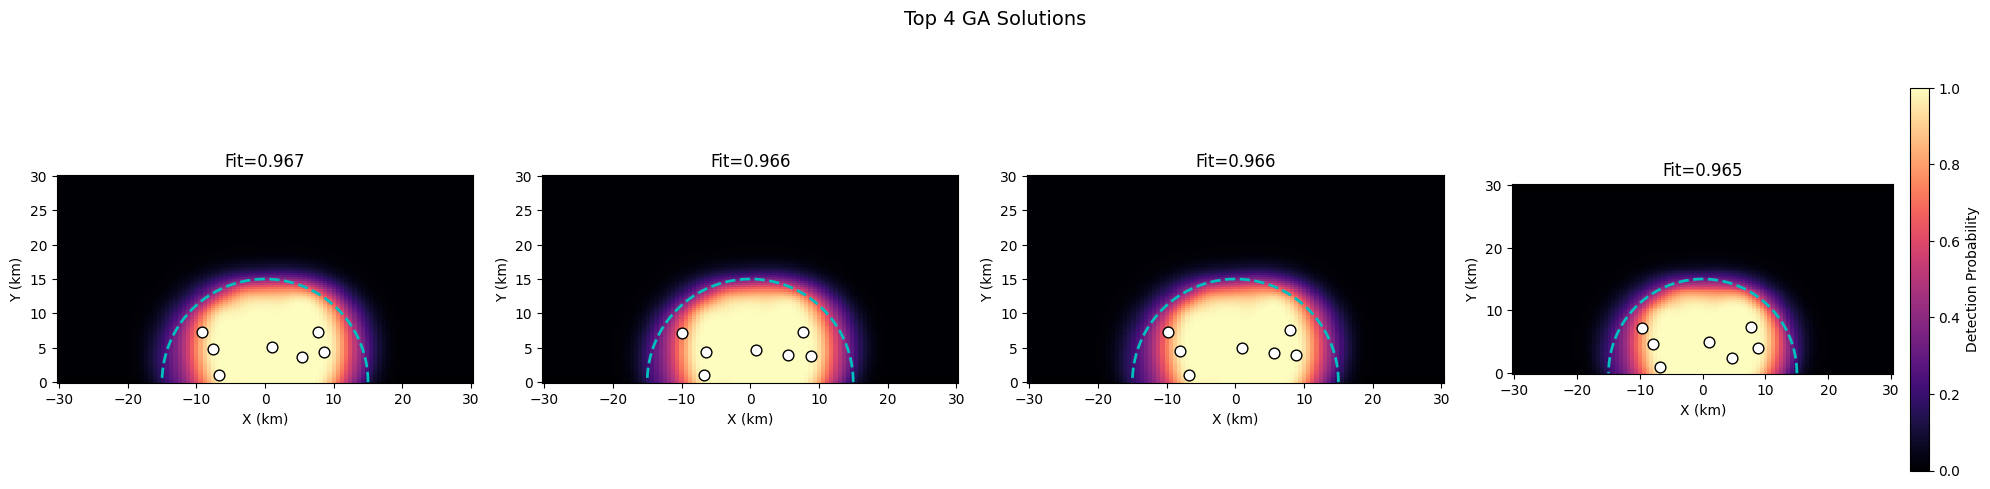

Gen 51 | Mean = 0.9562 | Best = 0.9666
Gen 52 | Mean = 0.9570 | Best = 0.9660
Gen 53 | Mean = 0.9527 | Best = 0.9655
Gen 54 | Mean = 0.9547 | Best = 0.9650
Gen 55 | Mean = 0.9540 | Best = 0.9645
Gen 56 | Mean = 0.9540 | Best = 0.9639
Gen 57 | Mean = 0.9540 | Best = 0.9634
Gen 58 | Mean = 0.9514 | Best = 0.9629
Gen 59 | Mean = 0.9471 | Best = 0.9624
Gen 60 | Mean = 0.9502 | Best = 0.9619
Gen 61 | Mean = 0.9475 | Best = 0.9614
Gen 62 | Mean = 0.9474 | Best = 0.9609
Gen 63 | Mean = 0.9466 | Best = 0.9604
Gen 64 | Mean = 0.9466 | Best = 0.9599
Gen 65 | Mean = 0.9463 | Best = 0.9594
Gen 66 | Mean = 0.9453 | Best = 0.9589
Gen 67 | Mean = 0.9469 | Best = 0.9584
Gen 68 | Mean = 0.9466 | Best = 0.9579
Gen 69 | Mean = 0.9475 | Best = 0.9574
Gen 70 | Mean = 0.9448 | Best = 0.9569
Gen 71 | Mean = 0.9453 | Best = 0.9564
Gen 72 | Mean = 0.9482 | Best = 0.9559
Gen 73 | Mean = 0.9430 | Best = 0.9554
Gen 74 | Mean = 0.9421 | Best = 0.9549
Gen 75 | Mean = 0.9432 | Best = 0.9545
Gen 76 | Mean = 0.9431 | 

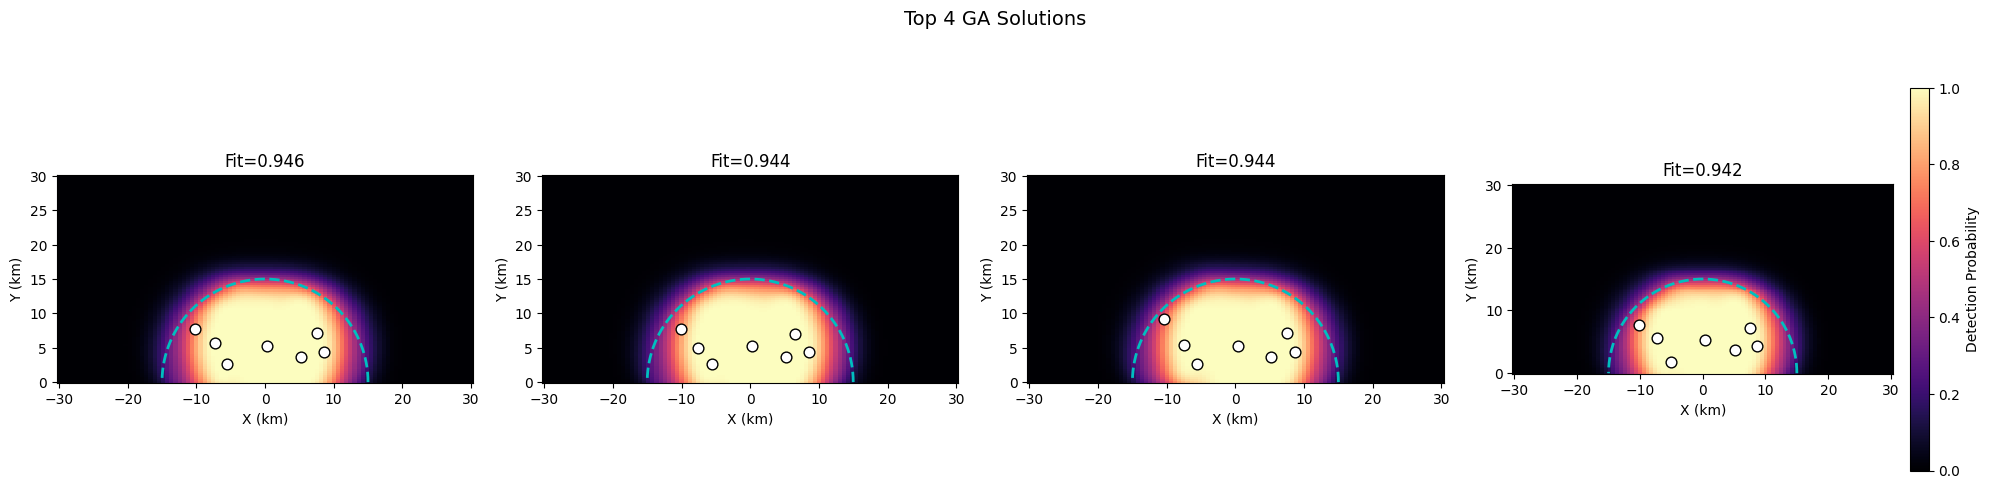

Gen 101 | Mean = 0.9355 | Best = 0.9452
Gen 102 | Mean = 0.9340 | Best = 0.9448
Gen 103 | Mean = 0.9321 | Best = 0.9444
Gen 104 | Mean = 0.9333 | Best = 0.9440
Gen 105 | Mean = 0.9312 | Best = 0.9436
Gen 106 | Mean = 0.9330 | Best = 0.9432
Gen 107 | Mean = 0.9316 | Best = 0.9428
Gen 108 | Mean = 0.9298 | Best = 0.9424
Gen 109 | Mean = 0.9318 | Best = 0.9420
Gen 110 | Mean = 0.9294 | Best = 0.9417
Gen 111 | Mean = 0.9305 | Best = 0.9413
Gen 112 | Mean = 0.9321 | Best = 0.9409
Gen 113 | Mean = 0.9294 | Best = 0.9405
Gen 114 | Mean = 0.9295 | Best = 0.9401
Gen 115 | Mean = 0.9308 | Best = 0.9398
Gen 116 | Mean = 0.9282 | Best = 0.9394
Gen 117 | Mean = 0.9246 | Best = 0.9390
Gen 118 | Mean = 0.9243 | Best = 0.9387
Gen 119 | Mean = 0.9310 | Best = 0.9383
Gen 120 | Mean = 0.9250 | Best = 0.9379
Gen 121 | Mean = 0.9256 | Best = 0.9376
Gen 122 | Mean = 0.9292 | Best = 0.9372
Gen 123 | Mean = 0.9270 | Best = 0.9369
Gen 124 | Mean = 0.9248 | Best = 0.9365
Gen 125 | Mean = 0.9258 | Best = 0.9362


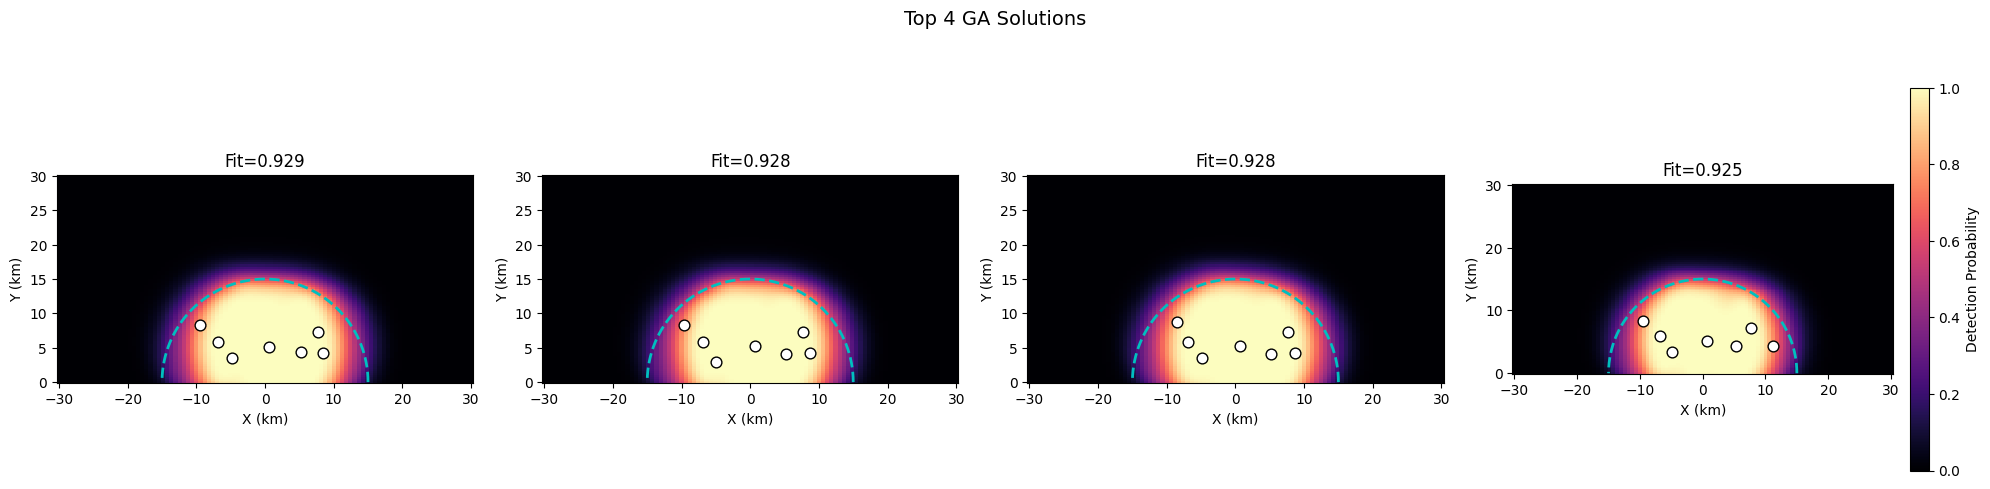

Gen 151 | Mean = 0.9159 | Best = 0.9288
Gen 152 | Mean = 0.9173 | Best = 0.9285
Gen 153 | Mean = 0.9130 | Best = 0.9282
Gen 154 | Mean = 0.9147 | Best = 0.9279
Gen 155 | Mean = 0.9158 | Best = 0.9276
Gen 156 | Mean = 0.9158 | Best = 0.9273
Gen 157 | Mean = 0.9136 | Best = 0.9270
Gen 158 | Mean = 0.9132 | Best = 0.9267
Gen 159 | Mean = 0.9127 | Best = 0.9264
Gen 160 | Mean = 0.9148 | Best = 0.9262
Gen 161 | Mean = 0.9115 | Best = 0.9259
Gen 162 | Mean = 0.9133 | Best = 0.9256
Gen 163 | Mean = 0.9123 | Best = 0.9253
Gen 164 | Mean = 0.9145 | Best = 0.9250
Gen 165 | Mean = 0.9117 | Best = 0.9247
Gen 166 | Mean = 0.9107 | Best = 0.9244
Gen 167 | Mean = 0.9095 | Best = 0.9241
Gen 168 | Mean = 0.9097 | Best = 0.9238
Gen 169 | Mean = 0.9113 | Best = 0.9236
Gen 170 | Mean = 0.9098 | Best = 0.9233
Gen 171 | Mean = 0.9136 | Best = 0.9230
Gen 172 | Mean = 0.9093 | Best = 0.9227
Gen 173 | Mean = 0.9090 | Best = 0.9224
Gen 174 | Mean = 0.9087 | Best = 0.9222
Gen 175 | Mean = 0.9057 | Best = 0.9219


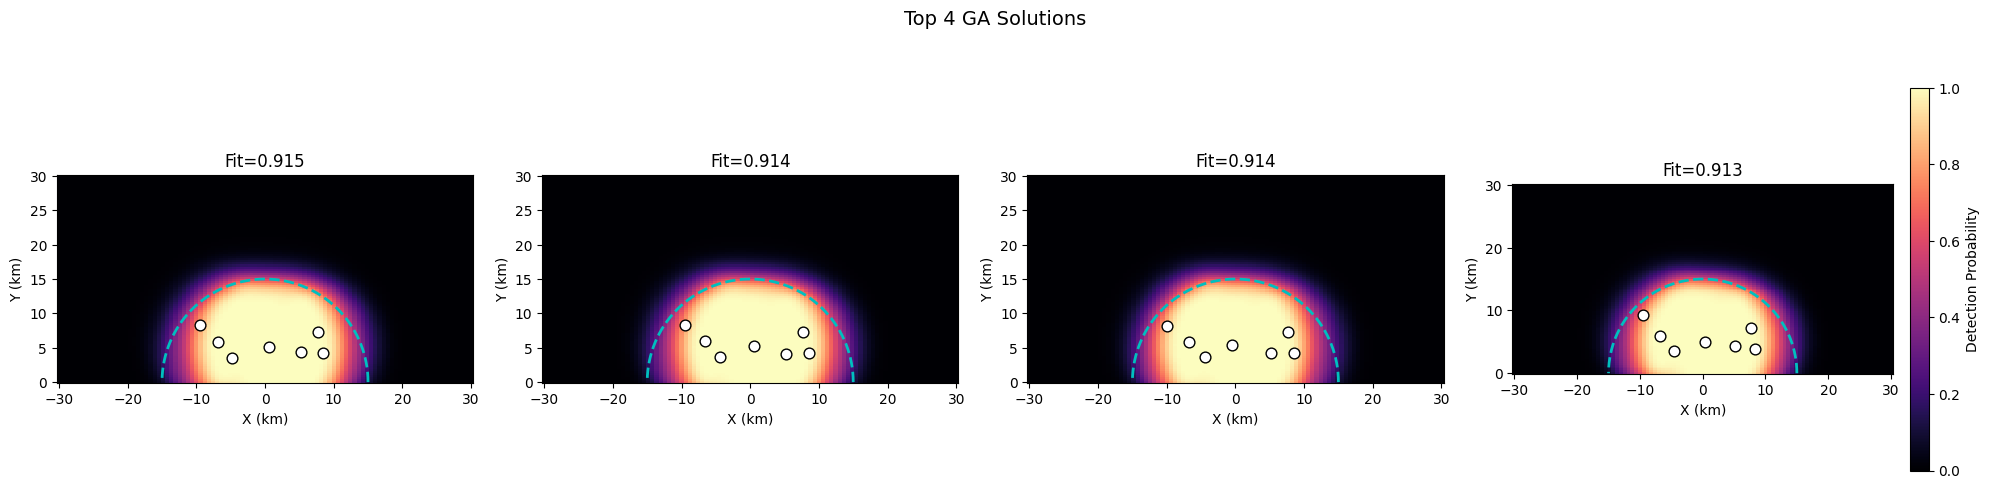

Gen 201 | Mean = 0.9049 | Best = 0.9151
Gen 202 | Mean = 0.9030 | Best = 0.9148
Gen 203 | Mean = 0.9033 | Best = 0.9146
Gen 204 | Mean = 0.8990 | Best = 0.9143
Gen 205 | Mean = 0.9006 | Best = 0.9141
Gen 206 | Mean = 0.8963 | Best = 0.9138
Gen 207 | Mean = 0.9013 | Best = 0.9136
Gen 208 | Mean = 0.8991 | Best = 0.9134
Gen 209 | Mean = 0.9005 | Best = 0.9131
Gen 210 | Mean = 0.9027 | Best = 0.9129
Gen 211 | Mean = 0.8988 | Best = 0.9126
Gen 212 | Mean = 0.8993 | Best = 0.9124
Gen 213 | Mean = 0.8984 | Best = 0.9122
Gen 214 | Mean = 0.8984 | Best = 0.9119
Gen 215 | Mean = 0.8954 | Best = 0.9117
Gen 216 | Mean = 0.8982 | Best = 0.9115
Gen 217 | Mean = 0.8966 | Best = 0.9112
Gen 218 | Mean = 0.8976 | Best = 0.9110
Gen 219 | Mean = 0.8977 | Best = 0.9108
Gen 220 | Mean = 0.9014 | Best = 0.9105
Gen 221 | Mean = 0.8981 | Best = 0.9103
Gen 222 | Mean = 0.8988 | Best = 0.9101
Gen 223 | Mean = 0.8958 | Best = 0.9098
Gen 224 | Mean = 0.8972 | Best = 0.9096
Gen 225 | Mean = 0.8967 | Best = 0.9094


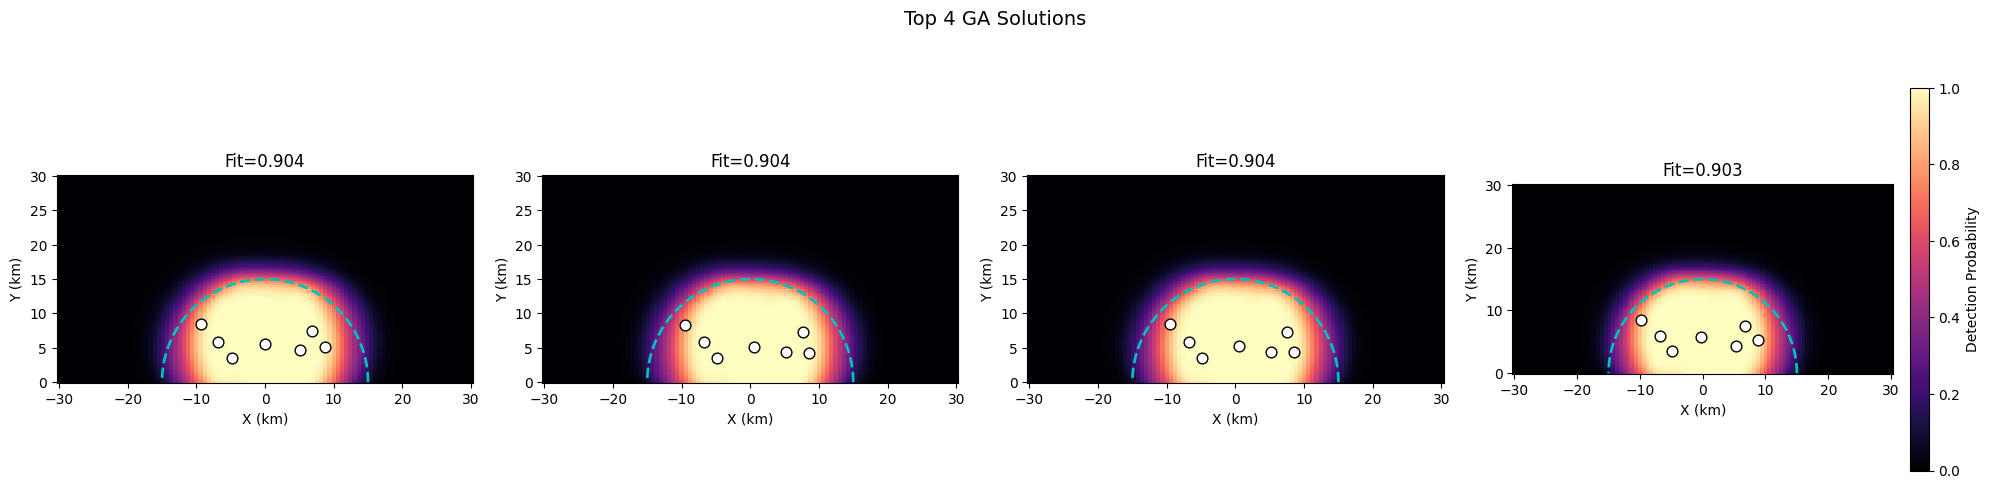

Gen 251 | Mean = 0.8907 | Best = 0.9043
Gen 252 | Mean = 0.8911 | Best = 0.9041
Gen 253 | Mean = 0.8865 | Best = 0.9039
Gen 254 | Mean = 0.8912 | Best = 0.9037
Gen 255 | Mean = 0.8912 | Best = 0.9035
Gen 256 | Mean = 0.8882 | Best = 0.9033
Gen 257 | Mean = 0.8874 | Best = 0.9032
Gen 258 | Mean = 0.8870 | Best = 0.9030
Gen 259 | Mean = 0.8877 | Best = 0.9028
Gen 260 | Mean = 0.8880 | Best = 0.9026
Gen 261 | Mean = 0.8912 | Best = 0.9027
Gen 262 | Mean = 0.8868 | Best = 0.9025
Gen 263 | Mean = 0.8877 | Best = 0.9023
Gen 264 | Mean = 0.8859 | Best = 0.9021
Gen 265 | Mean = 0.8884 | Best = 0.9019
Gen 266 | Mean = 0.8888 | Best = 0.9017
Gen 267 | Mean = 0.8892 | Best = 0.9016
Gen 268 | Mean = 0.8908 | Best = 0.9014
Gen 269 | Mean = 0.8866 | Best = 0.9012
Gen 270 | Mean = 0.8875 | Best = 0.9010
Gen 271 | Mean = 0.8881 | Best = 0.9008
Gen 272 | Mean = 0.8870 | Best = 0.9007
Gen 273 | Mean = 0.8874 | Best = 0.9005
Gen 274 | Mean = 0.8829 | Best = 0.9003
Gen 275 | Mean = 0.8895 | Best = 0.9001


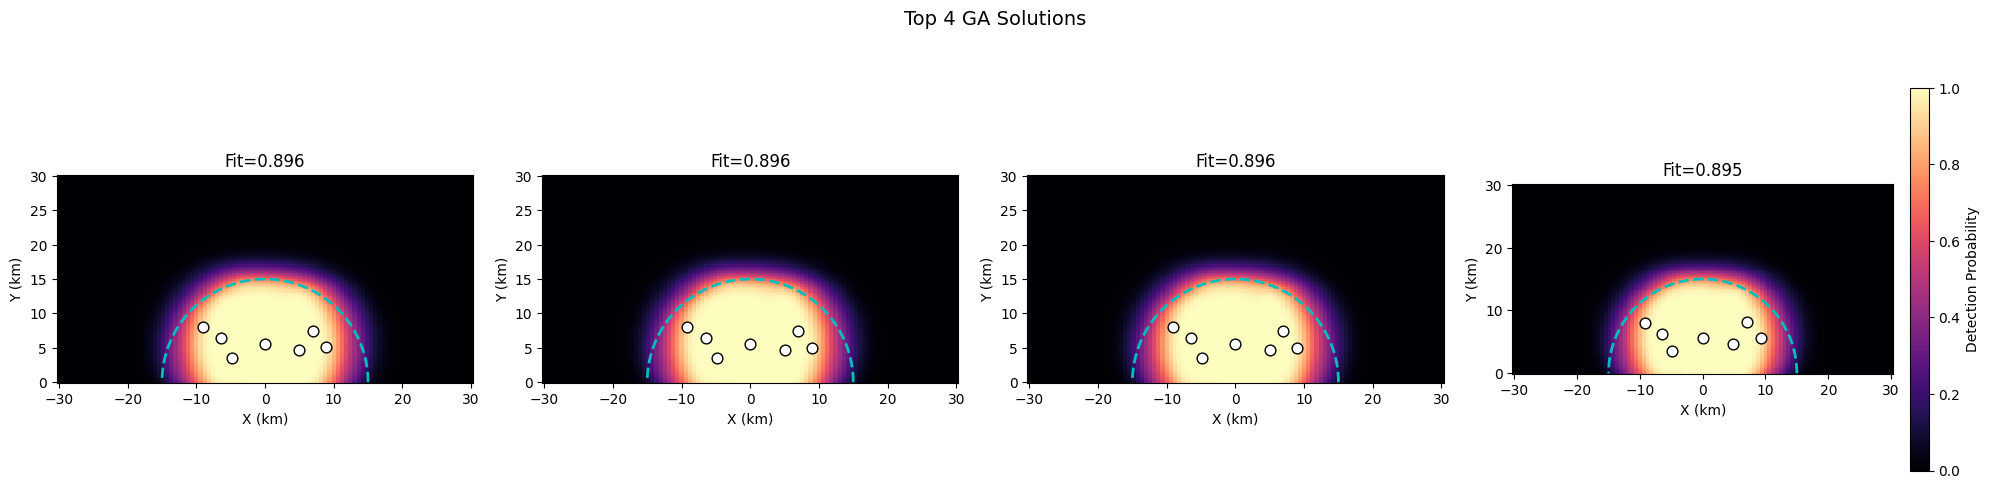

Gen 301 | Mean = 0.8827 | Best = 0.8960
Gen 302 | Mean = 0.8852 | Best = 0.8958
Gen 303 | Mean = 0.8826 | Best = 0.8957
Gen 304 | Mean = 0.8826 | Best = 0.8955
Gen 305 | Mean = 0.8831 | Best = 0.8954
Gen 306 | Mean = 0.8830 | Best = 0.8952
Gen 307 | Mean = 0.8809 | Best = 0.8951
Gen 308 | Mean = 0.8823 | Best = 0.8949
Gen 309 | Mean = 0.8785 | Best = 0.8948
Gen 310 | Mean = 0.8811 | Best = 0.8946
Gen 311 | Mean = 0.8811 | Best = 0.8945
Gen 312 | Mean = 0.8791 | Best = 0.8943
Gen 313 | Mean = 0.8771 | Best = 0.8941
Gen 314 | Mean = 0.8810 | Best = 0.8940
Gen 315 | Mean = 0.8789 | Best = 0.8938
Gen 316 | Mean = 0.8801 | Best = 0.8937
Gen 317 | Mean = 0.8778 | Best = 0.8936
Gen 318 | Mean = 0.8815 | Best = 0.8934
Gen 319 | Mean = 0.8823 | Best = 0.8933
Gen 320 | Mean = 0.8809 | Best = 0.8931
Gen 321 | Mean = 0.8800 | Best = 0.8930
Gen 322 | Mean = 0.8802 | Best = 0.8928
Gen 323 | Mean = 0.8781 | Best = 0.8927
Gen 324 | Mean = 0.8785 | Best = 0.8925
Gen 325 | Mean = 0.8808 | Best = 0.8924


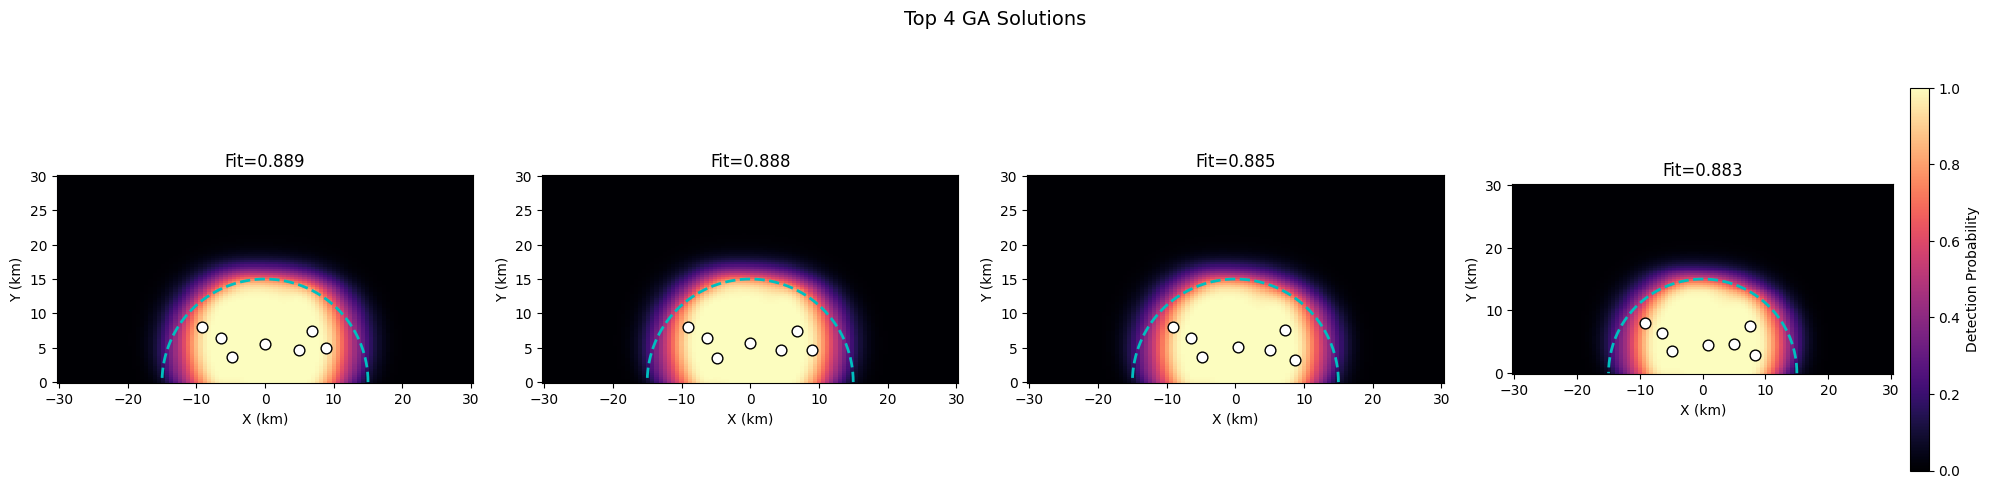

Gen 351 | Mean = 0.8749 | Best = 0.8889
Gen 352 | Mean = 0.8743 | Best = 0.8888
Gen 353 | Mean = 0.8766 | Best = 0.8887
Gen 354 | Mean = 0.8709 | Best = 0.8886
Gen 355 | Mean = 0.8690 | Best = 0.8884
Gen 356 | Mean = 0.8730 | Best = 0.8883
Gen 357 | Mean = 0.8720 | Best = 0.8882
Gen 358 | Mean = 0.8699 | Best = 0.8880
Gen 359 | Mean = 0.8716 | Best = 0.8879
Gen 360 | Mean = 0.8699 | Best = 0.8878
Gen 361 | Mean = 0.8720 | Best = 0.8877
Gen 362 | Mean = 0.8723 | Best = 0.8875
Gen 363 | Mean = 0.8757 | Best = 0.8874
Gen 364 | Mean = 0.8720 | Best = 0.8873
Gen 365 | Mean = 0.8731 | Best = 0.8872
Gen 366 | Mean = 0.8742 | Best = 0.8871
Gen 367 | Mean = 0.8708 | Best = 0.8869
Gen 368 | Mean = 0.8705 | Best = 0.8868
Gen 369 | Mean = 0.8743 | Best = 0.8867
Gen 370 | Mean = 0.8736 | Best = 0.8866
Gen 371 | Mean = 0.8743 | Best = 0.8865
Gen 372 | Mean = 0.8735 | Best = 0.8863
Gen 373 | Mean = 0.8733 | Best = 0.8862
Gen 374 | Mean = 0.8719 | Best = 0.8861
Gen 375 | Mean = 0.8758 | Best = 0.8860


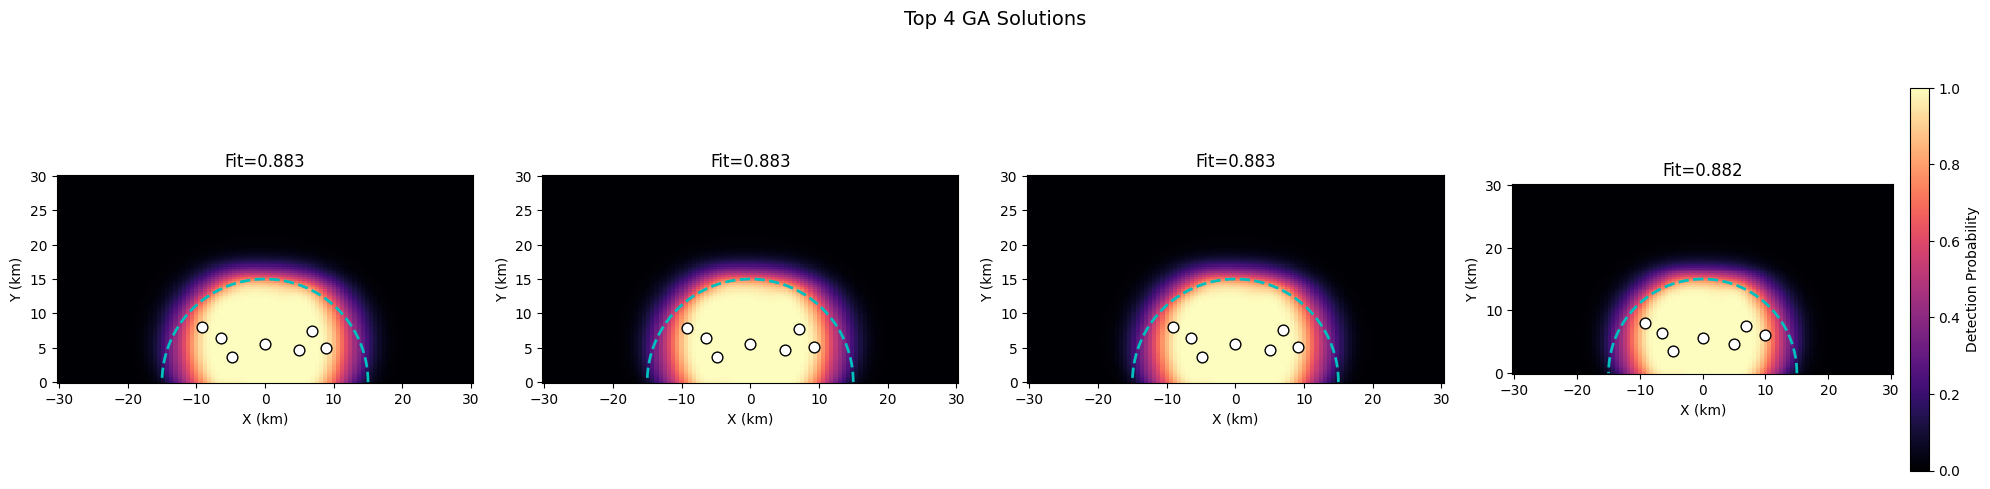

Gen 401 | Mean = 0.8659 | Best = 0.8831
Gen 402 | Mean = 0.8684 | Best = 0.8830
Gen 403 | Mean = 0.8690 | Best = 0.8829
Gen 404 | Mean = 0.8698 | Best = 0.8828
Gen 405 | Mean = 0.8682 | Best = 0.8827
Gen 406 | Mean = 0.8686 | Best = 0.8826
Gen 407 | Mean = 0.8665 | Best = 0.8825
Gen 408 | Mean = 0.8657 | Best = 0.8824
Gen 409 | Mean = 0.8695 | Best = 0.8822
Gen 410 | Mean = 0.8663 | Best = 0.8825
Gen 411 | Mean = 0.8602 | Best = 0.8824
Gen 412 | Mean = 0.8678 | Best = 0.8823
Gen 413 | Mean = 0.8660 | Best = 0.8822
Gen 414 | Mean = 0.8677 | Best = 0.8821
Gen 415 | Mean = 0.8689 | Best = 0.8820
Gen 416 | Mean = 0.8687 | Best = 0.8819
Gen 417 | Mean = 0.8659 | Best = 0.8818
Gen 418 | Mean = 0.8678 | Best = 0.8817
Gen 419 | Mean = 0.8679 | Best = 0.8816
Gen 420 | Mean = 0.8639 | Best = 0.8815
Gen 421 | Mean = 0.8660 | Best = 0.8814
Gen 422 | Mean = 0.8620 | Best = 0.8813
Gen 423 | Mean = 0.8679 | Best = 0.8812
Gen 424 | Mean = 0.8676 | Best = 0.8813
Gen 425 | Mean = 0.8692 | Best = 0.8812


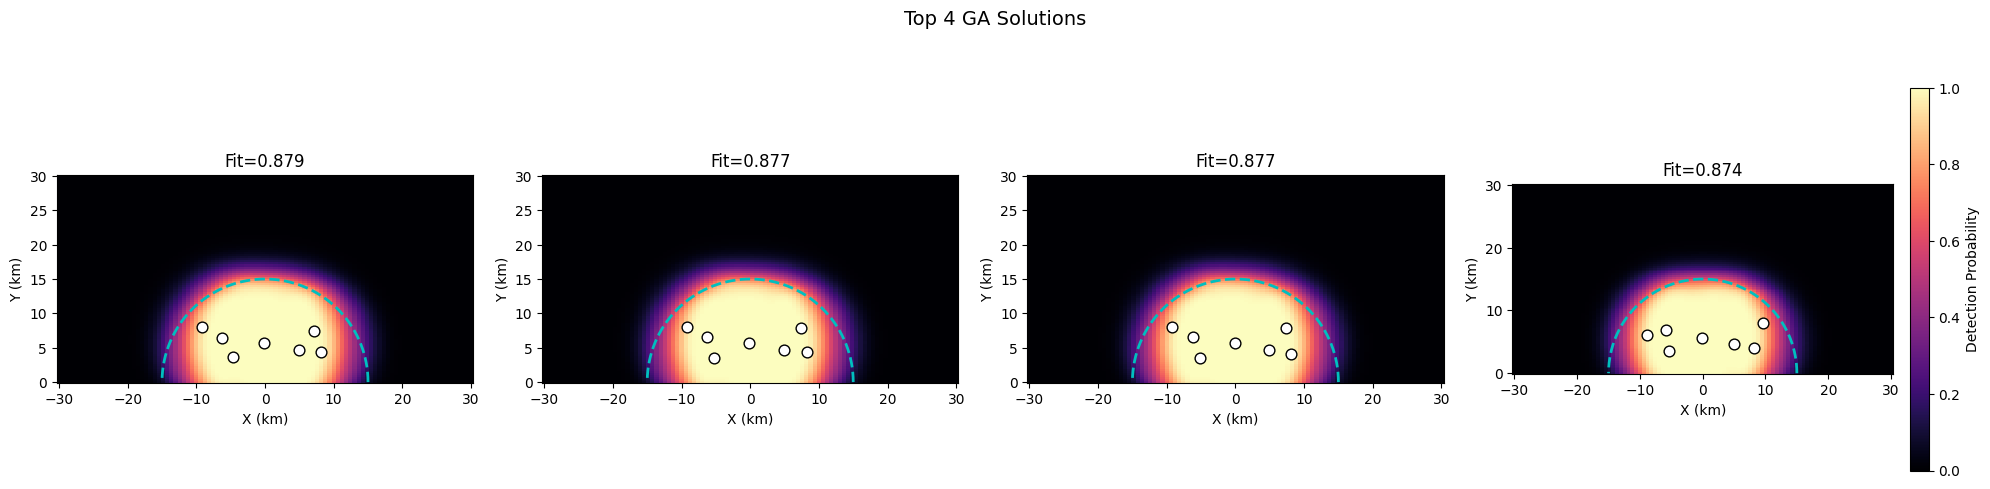

Gen 451 | Mean = 0.8603 | Best = 0.8790
Gen 452 | Mean = 0.8650 | Best = 0.8789
Gen 453 | Mean = 0.8612 | Best = 0.8788
Gen 454 | Mean = 0.8646 | Best = 0.8787
Gen 455 | Mean = 0.8641 | Best = 0.8786
Gen 456 | Mean = 0.8644 | Best = 0.8785
Gen 457 | Mean = 0.8627 | Best = 0.8785
Gen 458 | Mean = 0.8651 | Best = 0.8784
Gen 459 | Mean = 0.8619 | Best = 0.8783
Gen 460 | Mean = 0.8608 | Best = 0.8782
Gen 461 | Mean = 0.8637 | Best = 0.8781
Gen 462 | Mean = 0.8605 | Best = 0.8780
Gen 463 | Mean = 0.8625 | Best = 0.8780
Gen 464 | Mean = 0.8636 | Best = 0.8779
Gen 465 | Mean = 0.8630 | Best = 0.8778
Gen 466 | Mean = 0.8607 | Best = 0.8777
Gen 467 | Mean = 0.8630 | Best = 0.8776
Gen 468 | Mean = 0.8612 | Best = 0.8776
Gen 469 | Mean = 0.8607 | Best = 0.8775
Gen 470 | Mean = 0.8594 | Best = 0.8774
Gen 471 | Mean = 0.8649 | Best = 0.8773
Gen 472 | Mean = 0.8633 | Best = 0.8772
Gen 473 | Mean = 0.8640 | Best = 0.8772
Gen 474 | Mean = 0.8605 | Best = 0.8771
Gen 475 | Mean = 0.8612 | Best = 0.8770


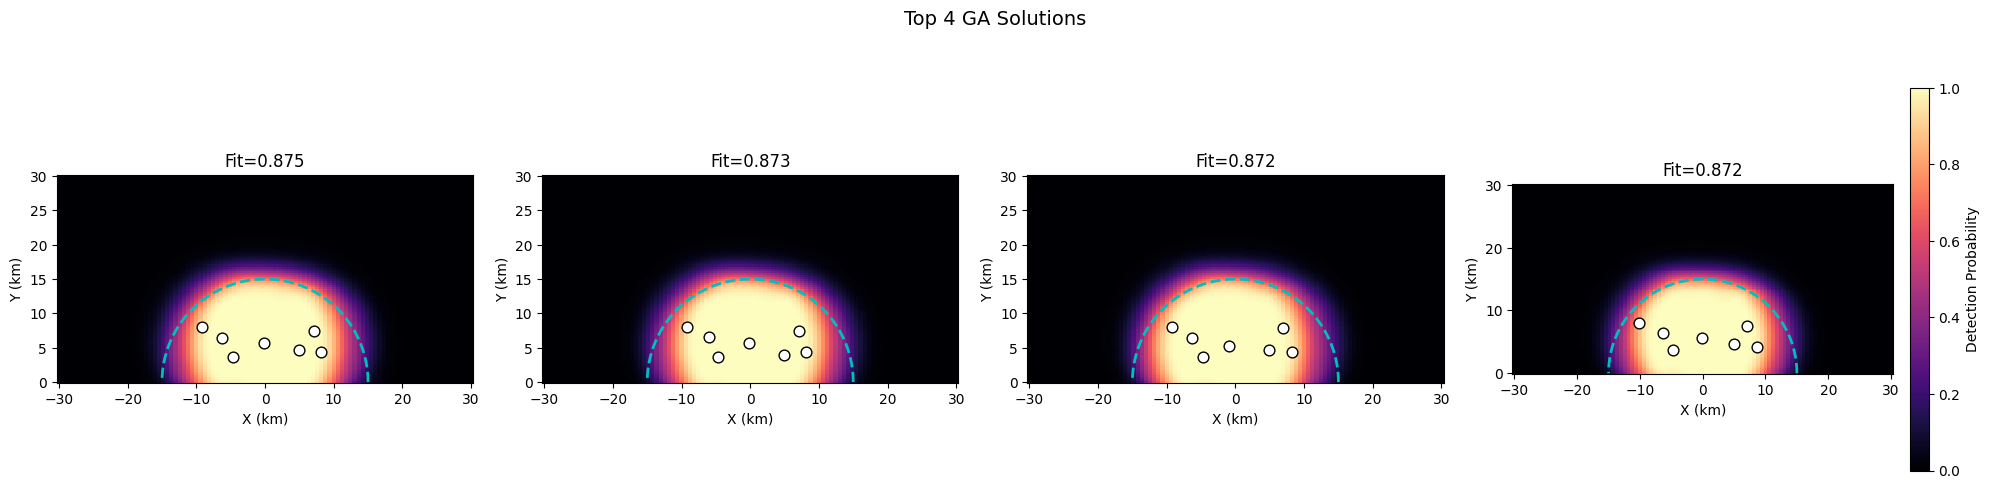

Gen 501 | Mean = 0.8567 | Best = 0.8751
Gen 502 | Mean = 0.8602 | Best = 0.8750
Gen 503 | Mean = 0.8591 | Best = 0.8749
Gen 504 | Mean = 0.8606 | Best = 0.8749
Gen 505 | Mean = 0.8578 | Best = 0.8748
Gen 506 | Mean = 0.8580 | Best = 0.8747
Gen 507 | Mean = 0.8583 | Best = 0.8746
Gen 508 | Mean = 0.8601 | Best = 0.8746
Gen 509 | Mean = 0.8571 | Best = 0.8745
Gen 510 | Mean = 0.8582 | Best = 0.8744
Gen 511 | Mean = 0.8607 | Best = 0.8744
Gen 512 | Mean = 0.8598 | Best = 0.8743
Gen 513 | Mean = 0.8605 | Best = 0.8742
Gen 514 | Mean = 0.8634 | Best = 0.8742
Gen 515 | Mean = 0.8594 | Best = 0.8741
Gen 516 | Mean = 0.8601 | Best = 0.8740
Gen 517 | Mean = 0.8598 | Best = 0.8740
Gen 518 | Mean = 0.8560 | Best = 0.8739
Gen 519 | Mean = 0.8559 | Best = 0.8738
Gen 520 | Mean = 0.8574 | Best = 0.8738
Gen 521 | Mean = 0.8619 | Best = 0.8737
Gen 522 | Mean = 0.8582 | Best = 0.8736
Gen 523 | Mean = 0.8550 | Best = 0.8736
Gen 524 | Mean = 0.8544 | Best = 0.8735
Gen 525 | Mean = 0.8585 | Best = 0.8735


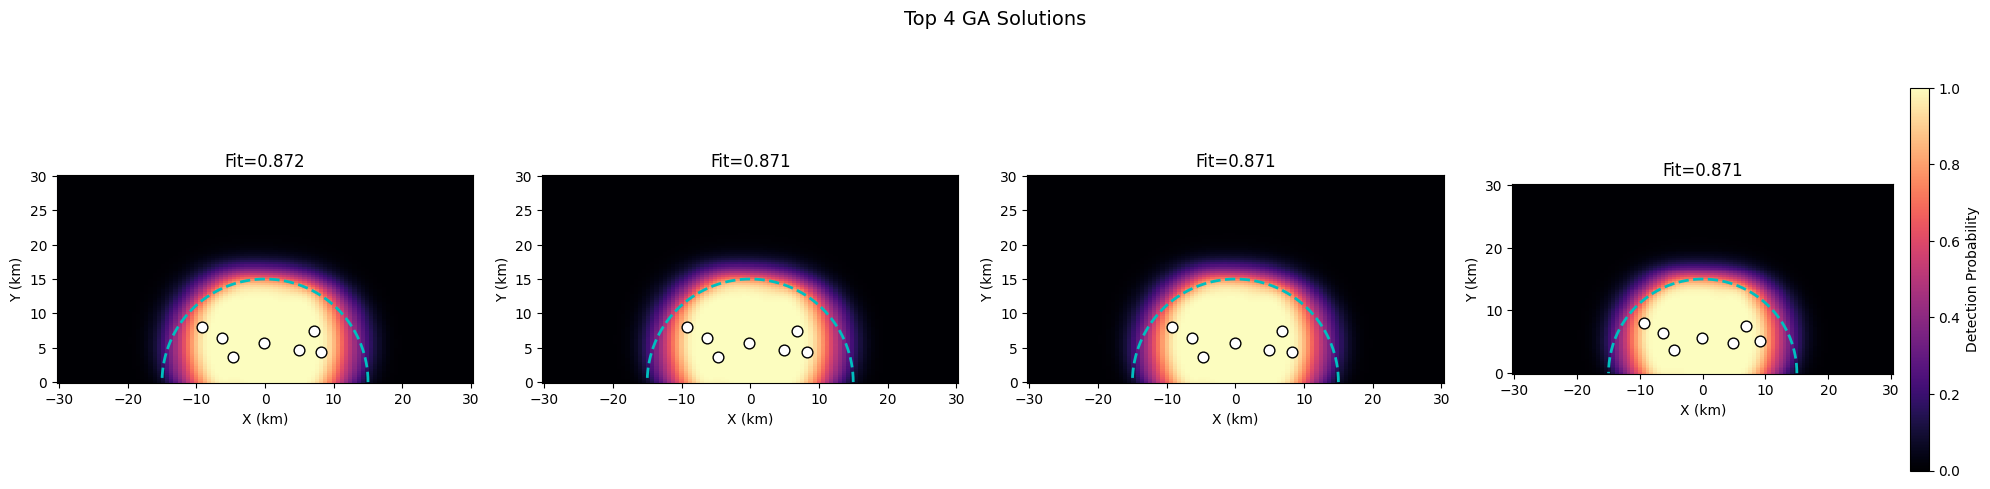

Gen 551 | Mean = 0.8587 | Best = 0.8719
Gen 552 | Mean = 0.8583 | Best = 0.8718
Gen 553 | Mean = 0.8575 | Best = 0.8718
Gen 554 | Mean = 0.8574 | Best = 0.8717
Gen 555 | Mean = 0.8552 | Best = 0.8716
Gen 556 | Mean = 0.8552 | Best = 0.8716
Gen 557 | Mean = 0.8549 | Best = 0.8715
Gen 558 | Mean = 0.8560 | Best = 0.8715
Gen 559 | Mean = 0.8556 | Best = 0.8714
Gen 560 | Mean = 0.8528 | Best = 0.8714
Gen 561 | Mean = 0.8533 | Best = 0.8713
Gen 562 | Mean = 0.8548 | Best = 0.8713
Gen 563 | Mean = 0.8613 | Best = 0.8712
Gen 564 | Mean = 0.8570 | Best = 0.8712
Gen 565 | Mean = 0.8544 | Best = 0.8711
Gen 566 | Mean = 0.8503 | Best = 0.8710
Gen 567 | Mean = 0.8558 | Best = 0.8710
Gen 568 | Mean = 0.8572 | Best = 0.8709
Gen 569 | Mean = 0.8494 | Best = 0.8709
Gen 570 | Mean = 0.8549 | Best = 0.8708
Gen 571 | Mean = 0.8546 | Best = 0.8708
Gen 572 | Mean = 0.8562 | Best = 0.8707
Gen 573 | Mean = 0.8538 | Best = 0.8707
Gen 574 | Mean = 0.8544 | Best = 0.8706
Gen 575 | Mean = 0.8521 | Best = 0.8706


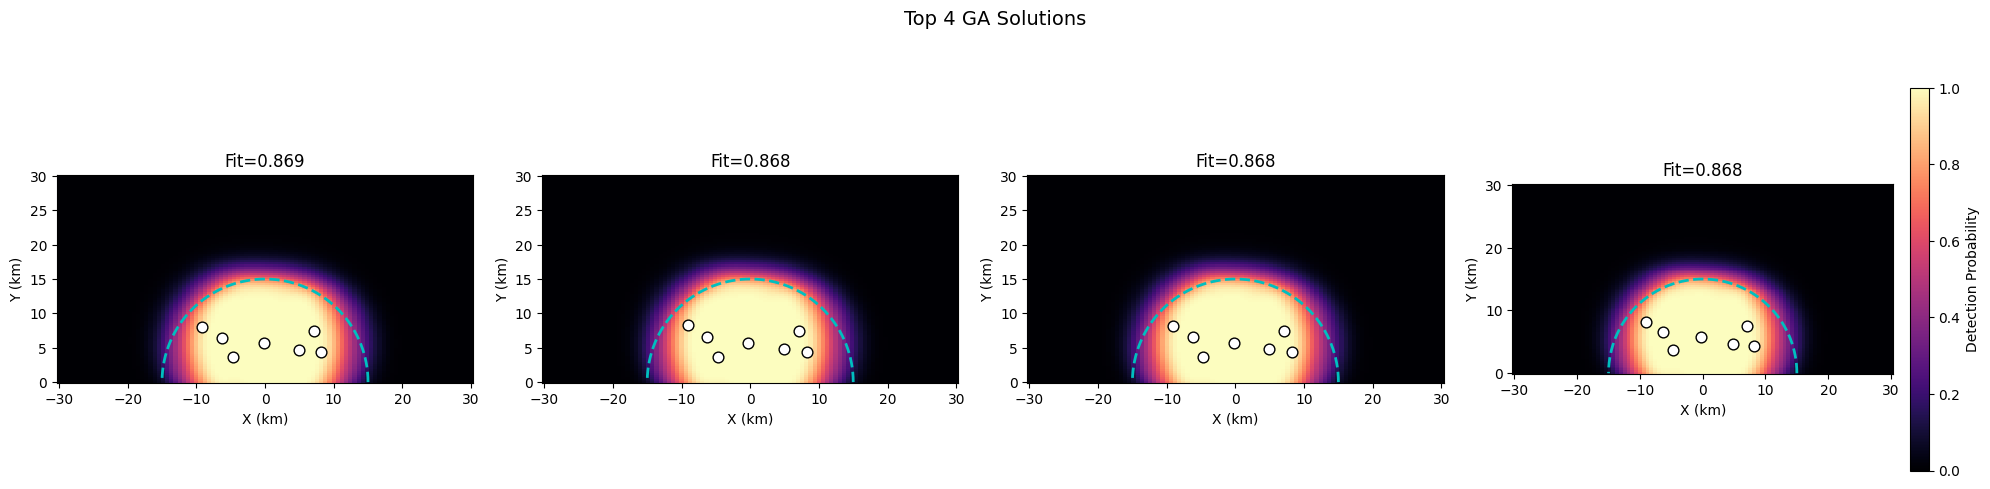

Gen 601 | Mean = 0.8531 | Best = 0.8693
Gen 602 | Mean = 0.8515 | Best = 0.8692
Gen 603 | Mean = 0.8538 | Best = 0.8692
Gen 604 | Mean = 0.8511 | Best = 0.8691
Gen 605 | Mean = 0.8552 | Best = 0.8691
Gen 606 | Mean = 0.8506 | Best = 0.8690
Gen 607 | Mean = 0.8514 | Best = 0.8690
Gen 608 | Mean = 0.8544 | Best = 0.8689
Gen 609 | Mean = 0.8532 | Best = 0.8689
Gen 610 | Mean = 0.8520 | Best = 0.8689
Gen 611 | Mean = 0.8561 | Best = 0.8688
Gen 612 | Mean = 0.8502 | Best = 0.8688
Gen 613 | Mean = 0.8511 | Best = 0.8687
Gen 614 | Mean = 0.8532 | Best = 0.8687
Gen 615 | Mean = 0.8530 | Best = 0.8686
Gen 616 | Mean = 0.8528 | Best = 0.8686
Gen 617 | Mean = 0.8510 | Best = 0.8685
Gen 618 | Mean = 0.8518 | Best = 0.8685
Gen 619 | Mean = 0.8539 | Best = 0.8685
Gen 620 | Mean = 0.8526 | Best = 0.8684
Gen 621 | Mean = 0.8490 | Best = 0.8684
Gen 622 | Mean = 0.8540 | Best = 0.8683
Gen 623 | Mean = 0.8471 | Best = 0.8683
Gen 624 | Mean = 0.8488 | Best = 0.8682
Gen 625 | Mean = 0.8489 | Best = 0.8682


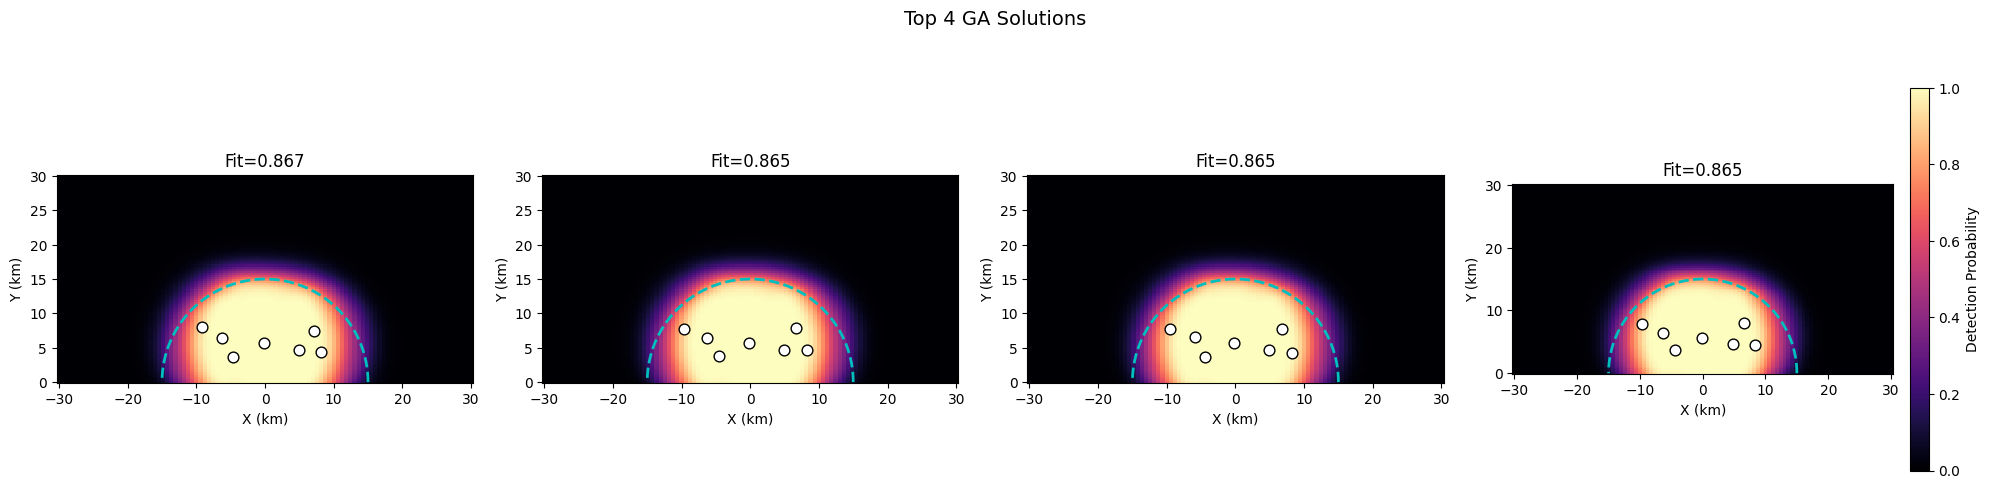

Gen 651 | Mean = 0.8516 | Best = 0.8671
Gen 652 | Mean = 0.8510 | Best = 0.8671
Gen 653 | Mean = 0.8524 | Best = 0.8671
Gen 654 | Mean = 0.8527 | Best = 0.8670
Gen 655 | Mean = 0.8494 | Best = 0.8670
Gen 656 | Mean = 0.8525 | Best = 0.8669
Gen 657 | Mean = 0.8529 | Best = 0.8669
Gen 658 | Mean = 0.8480 | Best = 0.8669
Gen 659 | Mean = 0.8525 | Best = 0.8668
Gen 660 | Mean = 0.8496 | Best = 0.8668
Gen 661 | Mean = 0.8517 | Best = 0.8668
Gen 662 | Mean = 0.8494 | Best = 0.8667
Gen 663 | Mean = 0.8509 | Best = 0.8667
Gen 664 | Mean = 0.8501 | Best = 0.8666
Gen 665 | Mean = 0.8525 | Best = 0.8666
Gen 666 | Mean = 0.8522 | Best = 0.8666
Gen 667 | Mean = 0.8529 | Best = 0.8665
Gen 668 | Mean = 0.8502 | Best = 0.8665
Gen 669 | Mean = 0.8501 | Best = 0.8665
Gen 670 | Mean = 0.8514 | Best = 0.8664
Gen 671 | Mean = 0.8501 | Best = 0.8664
Gen 672 | Mean = 0.8513 | Best = 0.8664
Gen 673 | Mean = 0.8513 | Best = 0.8663
Gen 674 | Mean = 0.8541 | Best = 0.8663
Gen 675 | Mean = 0.8525 | Best = 0.8662


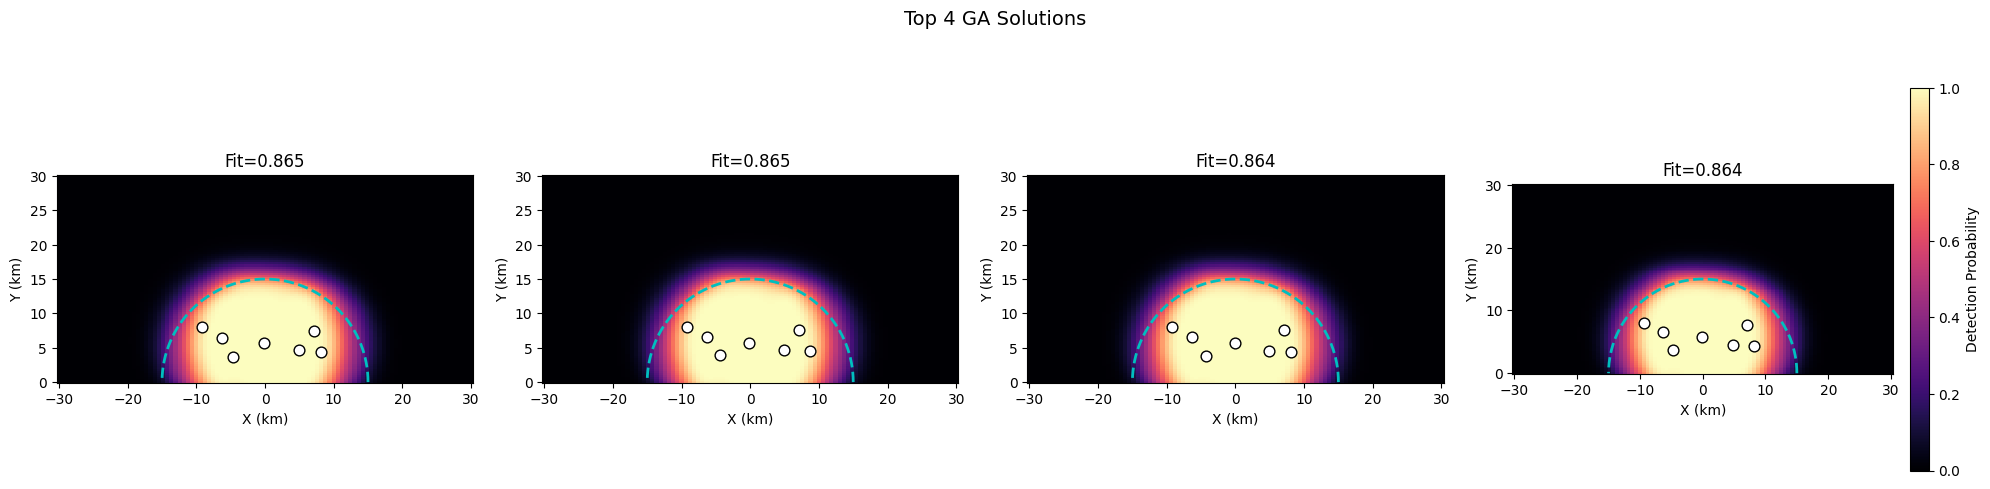

Gen 701 | Mean = 0.8502 | Best = 0.8654
Gen 702 | Mean = 0.8548 | Best = 0.8653
Gen 703 | Mean = 0.8516 | Best = 0.8653
Gen 704 | Mean = 0.8470 | Best = 0.8653
Gen 705 | Mean = 0.8502 | Best = 0.8653
Gen 706 | Mean = 0.8544 | Best = 0.8652
Gen 707 | Mean = 0.8532 | Best = 0.8652
Gen 708 | Mean = 0.8492 | Best = 0.8652
Gen 709 | Mean = 0.8465 | Best = 0.8651
Gen 710 | Mean = 0.8463 | Best = 0.8651
Gen 711 | Mean = 0.8455 | Best = 0.8651
Gen 712 | Mean = 0.8477 | Best = 0.8650
Gen 713 | Mean = 0.8465 | Best = 0.8650
Gen 714 | Mean = 0.8463 | Best = 0.8650
Gen 715 | Mean = 0.8483 | Best = 0.8649
Gen 716 | Mean = 0.8523 | Best = 0.8649
Gen 717 | Mean = 0.8502 | Best = 0.8649
Gen 718 | Mean = 0.8504 | Best = 0.8649
Gen 719 | Mean = 0.8454 | Best = 0.8648
Gen 720 | Mean = 0.8417 | Best = 0.8648
Gen 721 | Mean = 0.8406 | Best = 0.8648
Gen 722 | Mean = 0.8483 | Best = 0.8647
Gen 723 | Mean = 0.8509 | Best = 0.8647
Gen 724 | Mean = 0.8522 | Best = 0.8647
Gen 725 | Mean = 0.8486 | Best = 0.8647


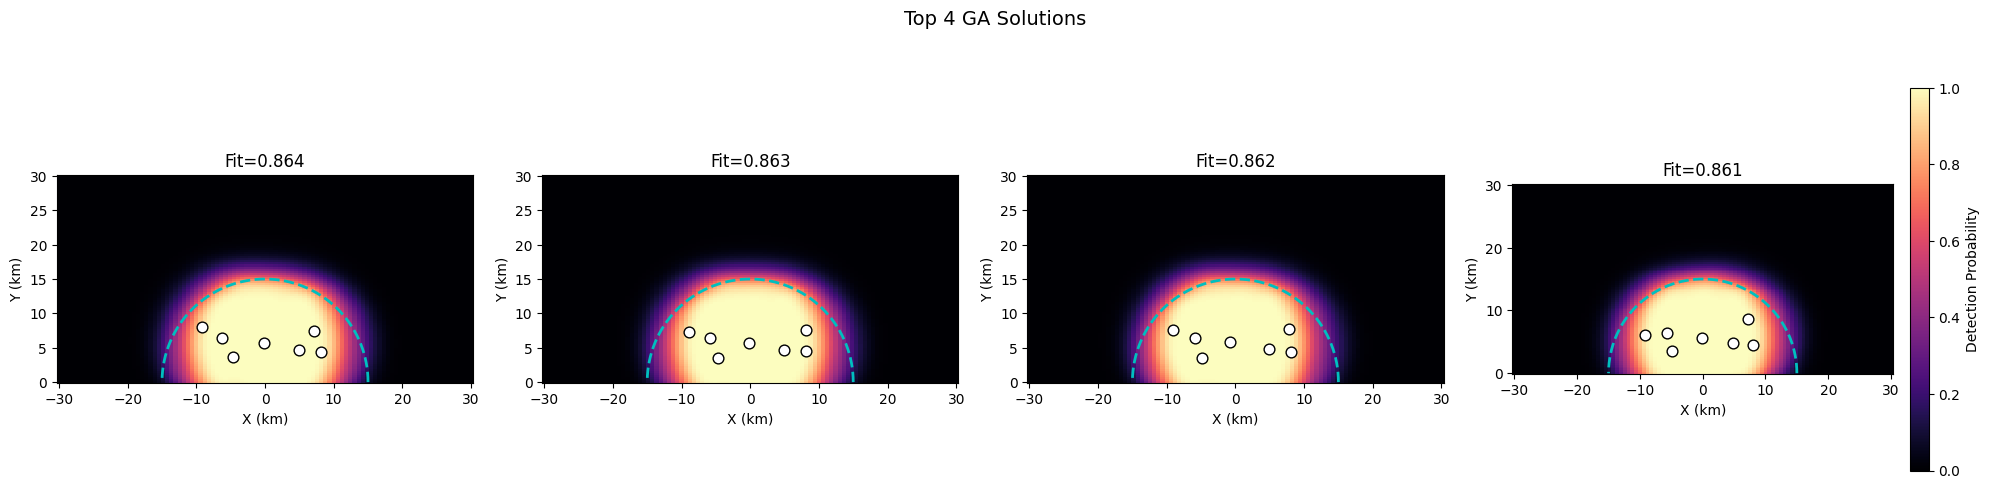

Gen 751 | Mean = 0.8509 | Best = 0.8639
Gen 752 | Mean = 0.8528 | Best = 0.8639
Gen 753 | Mean = 0.8491 | Best = 0.8639
Gen 754 | Mean = 0.8479 | Best = 0.8639
Gen 755 | Mean = 0.8449 | Best = 0.8638
Gen 756 | Mean = 0.8449 | Best = 0.8638
Gen 757 | Mean = 0.8483 | Best = 0.8638
Gen 758 | Mean = 0.8472 | Best = 0.8638
Gen 759 | Mean = 0.8437 | Best = 0.8637
Gen 760 | Mean = 0.8475 | Best = 0.8637
Gen 761 | Mean = 0.8446 | Best = 0.8637
Gen 762 | Mean = 0.8479 | Best = 0.8637
Gen 763 | Mean = 0.8473 | Best = 0.8636
Gen 764 | Mean = 0.8494 | Best = 0.8636
Gen 765 | Mean = 0.8481 | Best = 0.8636
Gen 766 | Mean = 0.8469 | Best = 0.8636
Gen 767 | Mean = 0.8473 | Best = 0.8635
Gen 768 | Mean = 0.8467 | Best = 0.8635
Gen 769 | Mean = 0.8490 | Best = 0.8635
Gen 770 | Mean = 0.8511 | Best = 0.8635
Gen 771 | Mean = 0.8473 | Best = 0.8634
Gen 772 | Mean = 0.8491 | Best = 0.8634
Gen 773 | Mean = 0.8512 | Best = 0.8634
Gen 774 | Mean = 0.8482 | Best = 0.8634
Gen 775 | Mean = 0.8450 | Best = 0.8633


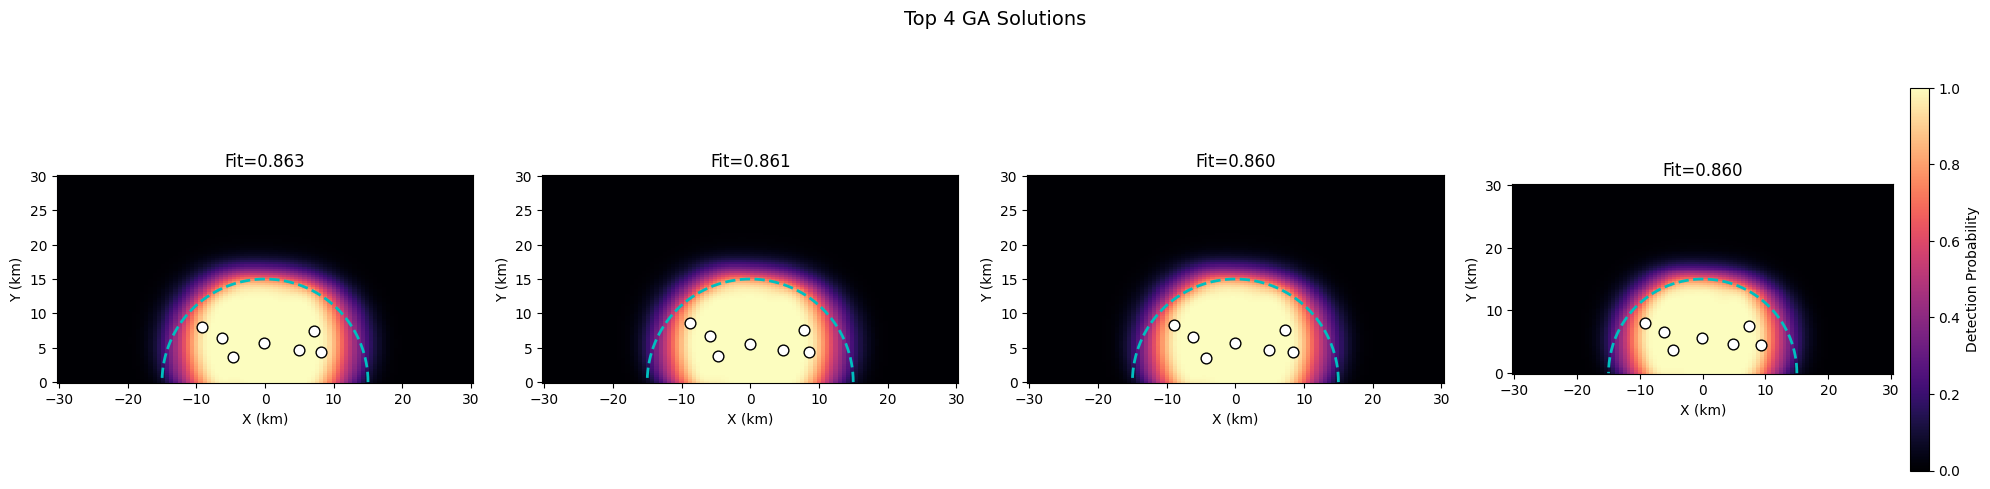

Gen 801 | Mean = 0.8459 | Best = 0.8628
Gen 802 | Mean = 0.8462 | Best = 0.8627
Gen 803 | Mean = 0.8457 | Best = 0.8627
Gen 804 | Mean = 0.8480 | Best = 0.8627
Gen 805 | Mean = 0.8430 | Best = 0.8627
Gen 806 | Mean = 0.8481 | Best = 0.8627
Gen 807 | Mean = 0.8468 | Best = 0.8626
Gen 808 | Mean = 0.8482 | Best = 0.8626
Gen 809 | Mean = 0.8470 | Best = 0.8626
Gen 810 | Mean = 0.8450 | Best = 0.8626
Gen 811 | Mean = 0.8473 | Best = 0.8626
Gen 812 | Mean = 0.8476 | Best = 0.8625
Gen 813 | Mean = 0.8467 | Best = 0.8625
Gen 814 | Mean = 0.8469 | Best = 0.8625
Gen 815 | Mean = 0.8427 | Best = 0.8625
Gen 816 | Mean = 0.8513 | Best = 0.8625
Gen 817 | Mean = 0.8448 | Best = 0.8624
Gen 818 | Mean = 0.8455 | Best = 0.8624
Gen 819 | Mean = 0.8438 | Best = 0.8624
Gen 820 | Mean = 0.8440 | Best = 0.8624
Gen 821 | Mean = 0.8455 | Best = 0.8624
Gen 822 | Mean = 0.8458 | Best = 0.8623
Gen 823 | Mean = 0.8462 | Best = 0.8623
Gen 824 | Mean = 0.8423 | Best = 0.8623
Gen 825 | Mean = 0.8444 | Best = 0.8623


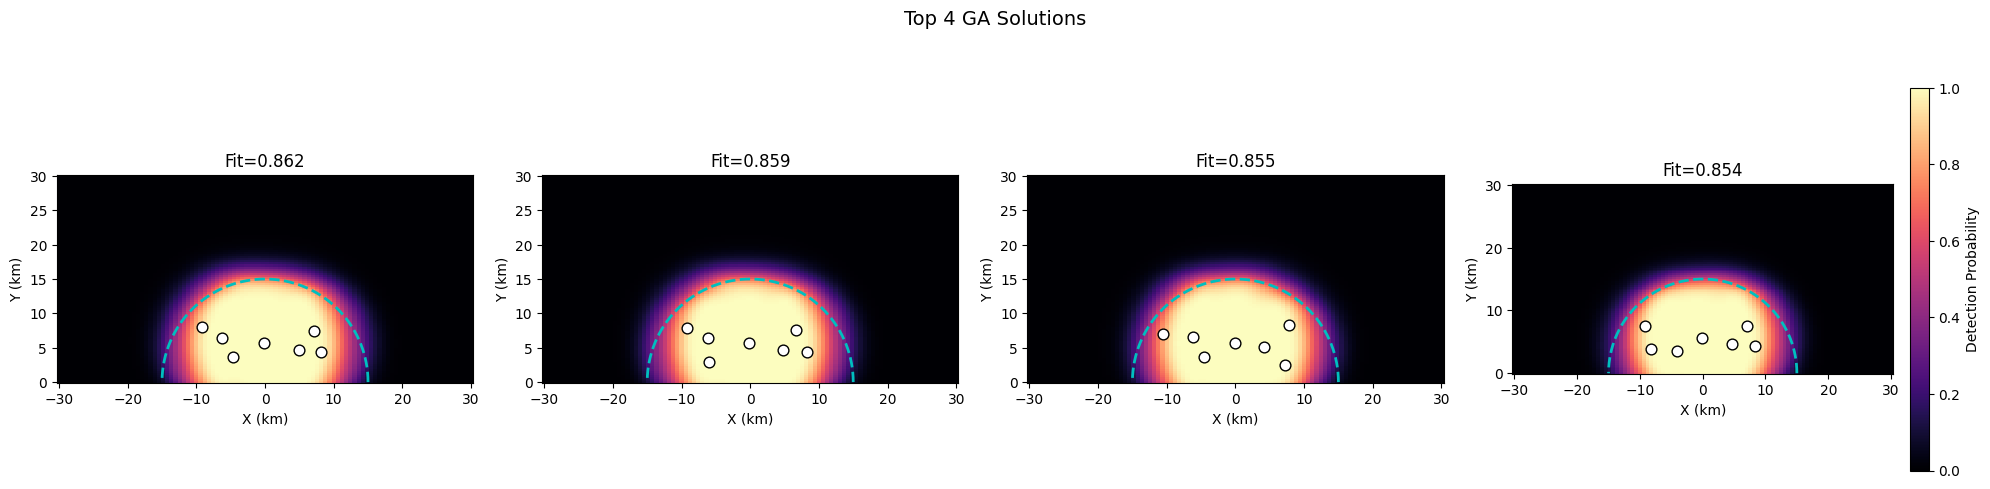

Gen 851 | Mean = 0.8431 | Best = 0.8618
Gen 852 | Mean = 0.8451 | Best = 0.8618
Gen 853 | Mean = 0.8456 | Best = 0.8618
Gen 854 | Mean = 0.8442 | Best = 0.8618
Gen 855 | Mean = 0.8477 | Best = 0.8617
Gen 856 | Mean = 0.8490 | Best = 0.8617
Gen 857 | Mean = 0.8450 | Best = 0.8617
Gen 858 | Mean = 0.8500 | Best = 0.8617
Gen 859 | Mean = 0.8446 | Best = 0.8617
Gen 860 | Mean = 0.8477 | Best = 0.8617
Gen 861 | Mean = 0.8471 | Best = 0.8616
Gen 862 | Mean = 0.8447 | Best = 0.8616
Gen 863 | Mean = 0.8447 | Best = 0.8616
Gen 864 | Mean = 0.8467 | Best = 0.8616
Gen 865 | Mean = 0.8429 | Best = 0.8616
Gen 866 | Mean = 0.8484 | Best = 0.8616
Gen 867 | Mean = 0.8460 | Best = 0.8615
Gen 868 | Mean = 0.8495 | Best = 0.8615
Gen 869 | Mean = 0.8467 | Best = 0.8615
Gen 870 | Mean = 0.8468 | Best = 0.8615
Gen 871 | Mean = 0.8455 | Best = 0.8615
Gen 872 | Mean = 0.8467 | Best = 0.8615
Gen 873 | Mean = 0.8473 | Best = 0.8614
Gen 874 | Mean = 0.8453 | Best = 0.8614
Gen 875 | Mean = 0.8450 | Best = 0.8614


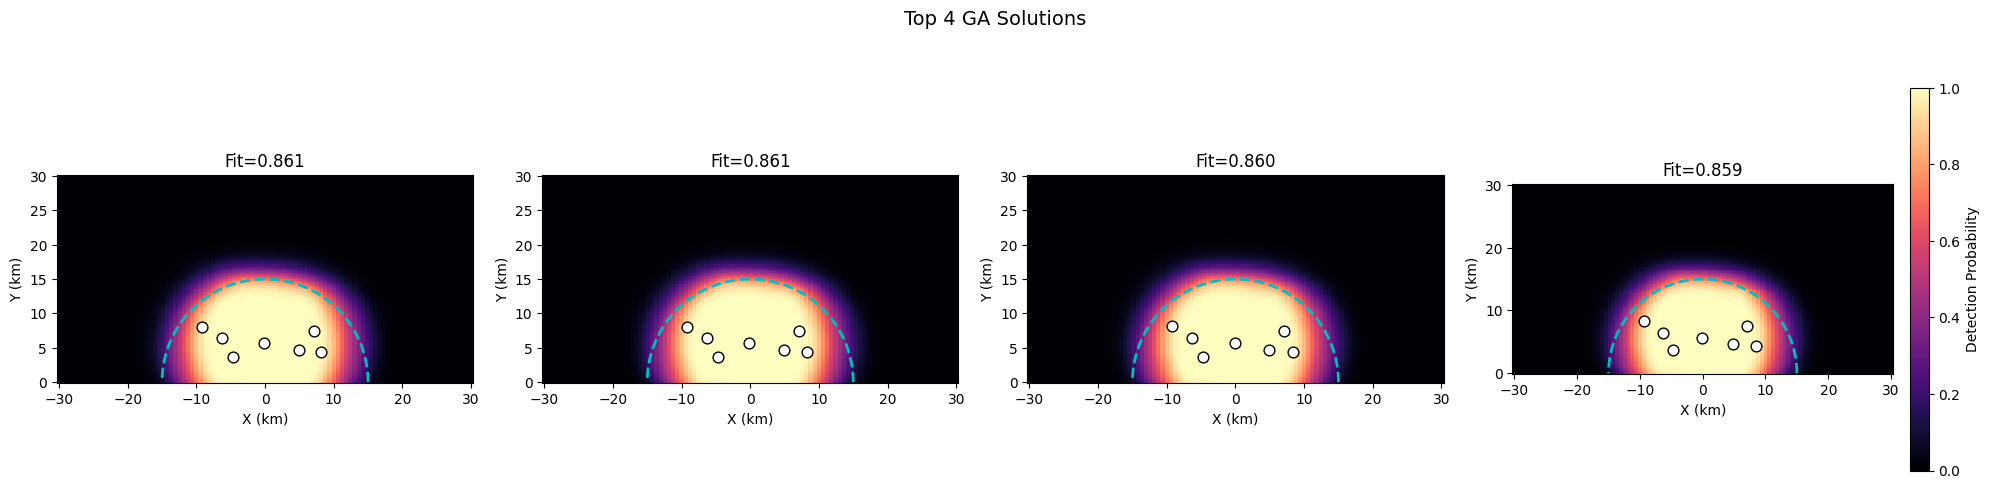

Gen 901 | Mean = 0.8472 | Best = 0.8610
Gen 902 | Mean = 0.8479 | Best = 0.8610
Gen 903 | Mean = 0.8441 | Best = 0.8610
Gen 904 | Mean = 0.8429 | Best = 0.8610
Gen 905 | Mean = 0.8466 | Best = 0.8610
Gen 906 | Mean = 0.8468 | Best = 0.8610
Gen 907 | Mean = 0.8450 | Best = 0.8609
Gen 908 | Mean = 0.8433 | Best = 0.8609
Gen 909 | Mean = 0.8446 | Best = 0.8609
Gen 910 | Mean = 0.8435 | Best = 0.8609
Gen 911 | Mean = 0.8457 | Best = 0.8609
Gen 912 | Mean = 0.8432 | Best = 0.8609
Gen 913 | Mean = 0.8450 | Best = 0.8609
Gen 914 | Mean = 0.8469 | Best = 0.8608
Gen 915 | Mean = 0.8470 | Best = 0.8608
Gen 916 | Mean = 0.8450 | Best = 0.8608
Gen 917 | Mean = 0.8422 | Best = 0.8608
Gen 918 | Mean = 0.8435 | Best = 0.8608
Gen 919 | Mean = 0.8411 | Best = 0.8608
Gen 920 | Mean = 0.8419 | Best = 0.8608
Gen 921 | Mean = 0.8446 | Best = 0.8607
Gen 922 | Mean = 0.8413 | Best = 0.8607
Gen 923 | Mean = 0.8443 | Best = 0.8607
Gen 924 | Mean = 0.8473 | Best = 0.8607
Gen 925 | Mean = 0.8397 | Best = 0.8607


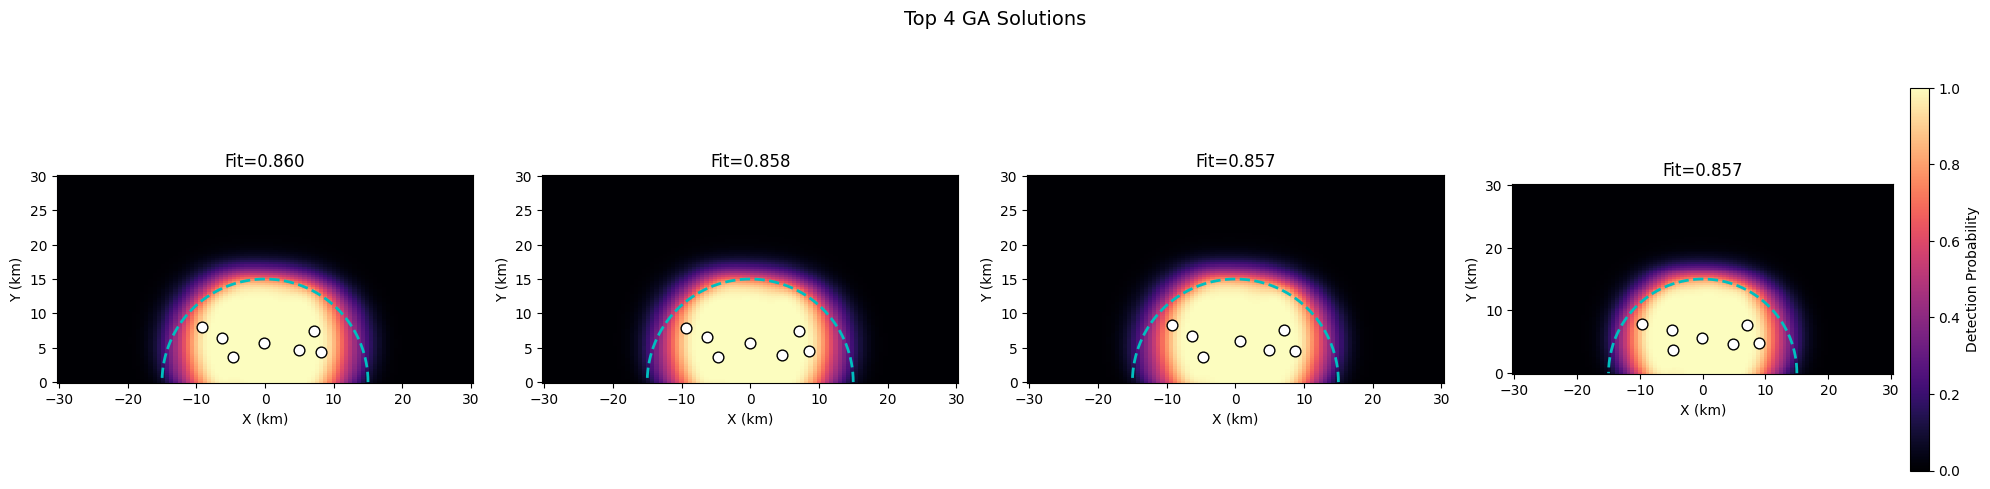

Gen 951 | Mean = 0.8415 | Best = 0.8604
Gen 952 | Mean = 0.8472 | Best = 0.8604
Gen 953 | Mean = 0.8443 | Best = 0.8604
Gen 954 | Mean = 0.8445 | Best = 0.8603
Gen 955 | Mean = 0.8422 | Best = 0.8603
Gen 956 | Mean = 0.8459 | Best = 0.8603
Gen 957 | Mean = 0.8408 | Best = 0.8603
Gen 958 | Mean = 0.8423 | Best = 0.8603
Gen 959 | Mean = 0.8427 | Best = 0.8603
Gen 960 | Mean = 0.8468 | Best = 0.8603
Gen 961 | Mean = 0.8442 | Best = 0.8603
Gen 962 | Mean = 0.8392 | Best = 0.8603
Gen 963 | Mean = 0.8420 | Best = 0.8602
Gen 964 | Mean = 0.8417 | Best = 0.8602
Gen 965 | Mean = 0.8462 | Best = 0.8602
Gen 966 | Mean = 0.8427 | Best = 0.8602
Gen 967 | Mean = 0.8448 | Best = 0.8602
Gen 968 | Mean = 0.8454 | Best = 0.8602
Gen 969 | Mean = 0.8432 | Best = 0.8602
Gen 970 | Mean = 0.8427 | Best = 0.8602
Gen 971 | Mean = 0.8439 | Best = 0.8602
Gen 972 | Mean = 0.8437 | Best = 0.8601
Gen 973 | Mean = 0.8440 | Best = 0.8601
Gen 974 | Mean = 0.8443 | Best = 0.8601
Gen 975 | Mean = 0.8453 | Best = 0.8601


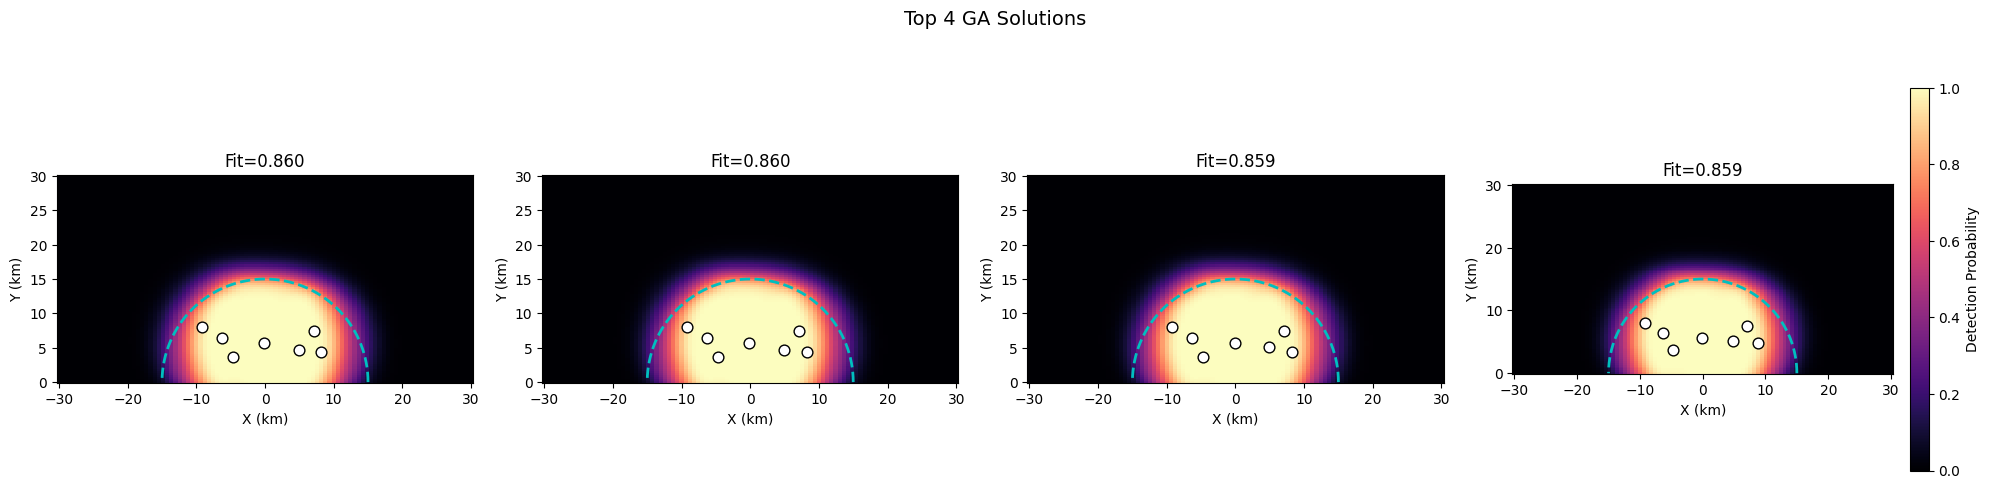

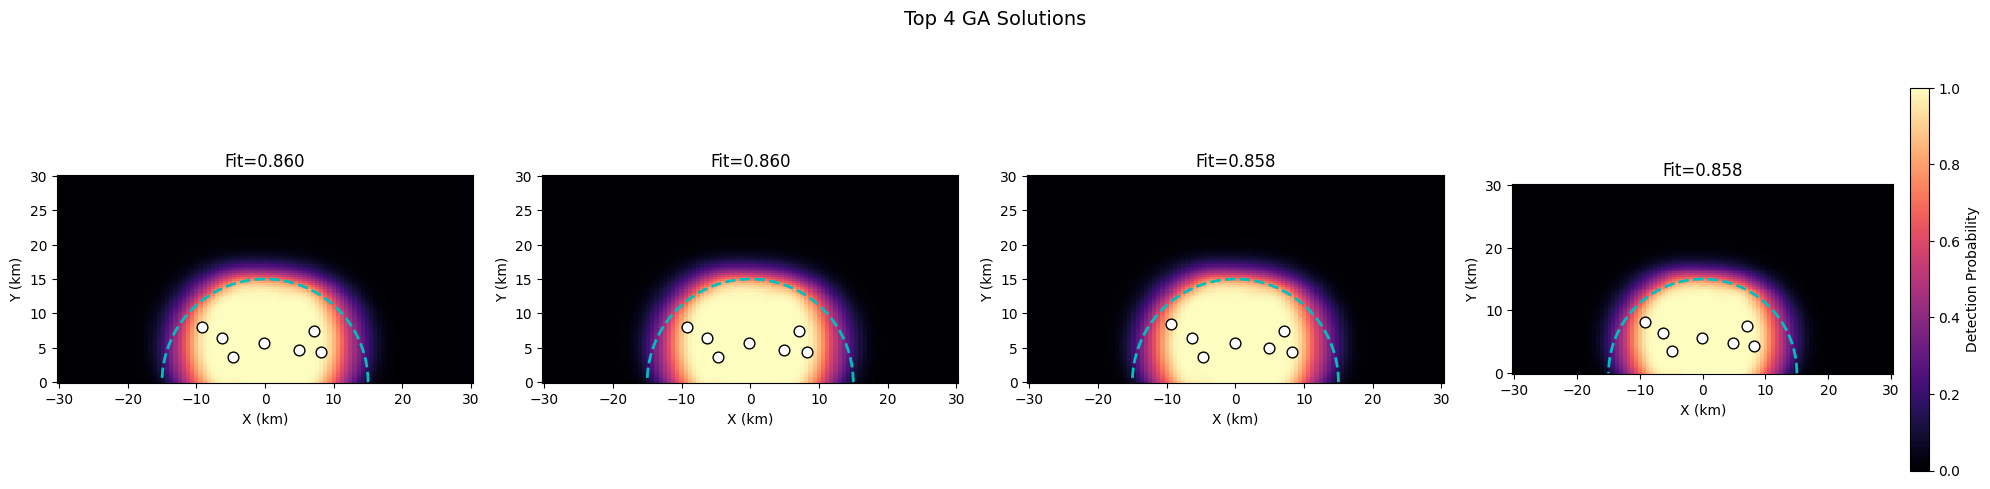

In [ ]:
env = Environment(grid_x, grid_y, det_func, compute_distances, calculate_probs,
                  detection_probabilities, detection_probabilities_single, mean_probability_in_semicircle, min_probability_in_semicircle, semicircle_mask, generations=1000, empty_penalty_fraction=1, mutation_rate = 0.3, metric='maxmin', radius=15.0, num_recorders=7, alpha_curve='expo')
best, scores = env.run(k_top=4)


In [ ]:
nv = Environment(grid_x, grid_y, det_func, compute_distances, calculate_probs,
                  detection_probabilities, detection_probabilities_single, mean_probability_in_semicircle, min_probability_in_semicircle, semicircle_mask, generations=1000, empty_penalty_fraction=1, mutation_rate = 0.3, metric='mean', radius=15.0, num_recorders=7)
best, scores = env.run(k_top=4)